# AD 2-Stage Inference + CAM Visualization

**Stage 1**: CN vs CI (MCI+AD) — `cn_f189.pth` (MCIClassifierWithAttention)

**Stage 2**: MCI vs AD — `ci_f184.pth` (MCIClassifier3D)

전체 데이터(7.data_mci,ad)를 분석하고, **MCI 정답을 맞춘 이미지**에 대해 ROI / Grad-CAM / Pixel-Gradient / PCG-CAM 시각화를 수행합니다.

In [1]:
from __future__ import annotations

import re
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import nibabel as nib
import matplotlib.pyplot as plt
from tqdm import tqdm

---
## 설정

In [ ]:
BASE_DIR = Path("/Users/machanho/Desktop/uv/ad")

CN_MODEL_PATH = BASE_DIR / "1.pth"   # Stage 1: CN vs CI
CI_MODEL_PATH = BASE_DIR / "test.pth"   # Stage 2: MCI vs AD
DATA_DIR = BASE_DIR / "7.data_mci,ad"
METADATA_PATH = BASE_DIR / "idaSearch_image_download_metadata_2510.csv"
OUTPUT_DIR = BASE_DIR / "inference_output5"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

TARGET_SHAPE = (96, 112, 96)
NUM_CLASSES = 2
DROPOUT = 0.25

# CAM 시각화할 MCI 정답 샘플 최대 개수
MAX_CAM_SAMPLES = 5

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

DEVICE = get_device()
print(f"Using device: {DEVICE}")

Using device: mps


---
## ROI 설정

In [3]:
ROI_DEFINITIONS = {
    # A. 내측 측두엽 (MTL)
    "hippocampus_L":      {"center": [48, 54, 36], "sigma": 4.0,  "weight": 2.0, "description": "좌측 해마 - MCI/AD 핵심"},
    "hippocampus_R":      {"center": [48, 54, 60], "sigma": 4.0,  "weight": 2.0, "description": "우측 해마"},
    "entorhinal_L":       {"center": [54, 48, 34], "sigma": 3.5,  "weight": 2.0, "description": "좌측 엔토라이날 - MCI 초기"},
    "entorhinal_R":       {"center": [54, 48, 62], "sigma": 3.5,  "weight": 2.0, "description": "우측 엔토라이날"},
    "parahippocampal_L":  {"center": [48, 42, 32], "sigma": 4.0,  "weight": 1.6, "description": "좌측 해마방회"},
    "parahippocampal_R":  {"center": [48, 42, 64], "sigma": 4.0,  "weight": 1.6, "description": "우측 해마방회"},
    "amygdala_L":         {"center": [42, 60, 34], "sigma": 3.5,  "weight": 1.5, "description": "좌측 편도체"},
    "amygdala_R":         {"center": [42, 60, 62], "sigma": 3.5,  "weight": 1.5, "description": "우측 편도체"},
    # B. AD signature + 연관 피질 영역
    "posterior_cingulate": {"center": [30, 35, 48], "sigma": 5.0,  "weight": 1.4, "description": "후대상피질 - AD 확장 패턴"},
    "precuneus":          {"center": [65, 30, 48], "sigma": 6.0,  "weight": 1.4, "description": "precuneus - AD 확장 패턴"},
    "inferior_temporal_L": {"center": [42, 60, 22], "sigma": 8.0, "weight": 1.3, "description": "좌측 하측두회"},
    "inferior_temporal_R": {"center": [42, 60, 72], "sigma": 8.0, "weight": 1.3, "description": "우측 하측두회"},
    "middle_temporal_L":  {"center": [48, 52, 24], "sigma": 8.0,  "weight": 1.3, "description": "좌측 중측두회"},
    "middle_temporal_R":  {"center": [48, 52, 72], "sigma": 8.0,  "weight": 1.3, "description": "우측 중측두회"},
    "fusiform_L":         {"center": [38, 58, 28], "sigma": 6.0,  "weight": 1.3, "description": "좌측 방추상회"},
    "fusiform_R":         {"center": [38, 58, 68], "sigma": 6.0,  "weight": 1.3, "description": "우측 방추상회"},
    "parietal_L":         {"center": [68, 45, 26], "sigma": 8.0,  "weight": 1.2, "description": "좌측 두정엽"},
    "parietal_R":         {"center": [68, 45, 70], "sigma": 8.0,  "weight": 1.2, "description": "우측 두정엽"},
    "frontal":            {"center": [55, 85, 48], "sigma": 10.0, "weight": 1.1, "description": "전두엽 - 후기 확장"},
    # C. 뇌실 (Ventricles)
    "lateral_ventricle":  {"center": [35, 56, 48], "sigma": 12.0, "weight": 1.5, "description": "측뇌실 - 위축 보상 확장"},
    "inferior_horn_L":    {"center": [35, 56, 30], "sigma": 8.0,  "weight": 1.5, "description": "좌측 하각 - 해마 위축 지표"},
    "inferior_horn_R":    {"center": [35, 56, 66], "sigma": 8.0,  "weight": 1.5, "description": "우측 하각"},
}

BASE_WEIGHT = 1.0

print(f"ROI 수: {len(ROI_DEFINITIONS)}")

ROI 수: 22


---
## 모델 정의

In [4]:
# ============================================================
# ROI Spatial Attention
# ============================================================

def create_roi_weight_map(
    target_shape: tuple[int, int, int],
    roi_definitions: dict,
    base_weight: float = BASE_WEIGHT
) -> torch.Tensor:
    D, H, W = target_shape
    weight_map = torch.ones(1, 1, D, H, W) * base_weight
    d = torch.arange(D).float()
    h = torch.arange(H).float()
    w = torch.arange(W).float()
    dd, hh, ww = torch.meshgrid(d, h, w, indexing='ij')
    for name, roi in roi_definitions.items():
        center = roi["center"]
        sigma = roi["sigma"]
        roi_weight = roi["weight"]
        dist_sq = ((dd - center[0])**2 + (hh - center[1])**2 + (ww - center[2])**2)
        gaussian = torch.exp(-dist_sq / (2 * sigma**2))
        weight_map[0, 0] += gaussian * max(0.0, roi_weight - base_weight)
    return weight_map


class ROISpatialAttention(nn.Module):
    def __init__(self, target_shape, roi_definitions, base_weight=1.0):
        super().__init__()
        weight_map = create_roi_weight_map(target_shape, roi_definitions, base_weight)
        self.register_buffer('weight_map', weight_map)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x * self.weight_map


# ============================================================
# Building Blocks
# ============================================================

class ConvBlock3D(nn.Module):
    def __init__(self, in_ch: int, out_ch: int) -> None:
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.block(x)


class ChannelAttention(nn.Module):
    def __init__(self, channels: int, reduction: int = 8) -> None:
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, c, _, _, _ = x.shape
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1, 1)
        return x * y


# ============================================================
# Stage 1 Model: MCIClassifierWithAttention (CN vs CI)
# ============================================================

class MCIClassifierWithAttention(nn.Module):
    def __init__(self, num_classes=2, dropout=DROPOUT, roi_attention=None):
        super().__init__()
        self.roi_attention = roi_attention
        self.block1 = ConvBlock3D(1, 32)
        self.block2 = ConvBlock3D(32, 64)
        self.block3 = ConvBlock3D(64, 128)
        self.block4 = ConvBlock3D(128, 256)
        self.attn = ChannelAttention(256)
        self.pool = nn.AdaptiveAvgPool3d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.roi_attention is not None:
            x = self.roi_attention(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.attn(x)
        x = self.pool(x)
        return self.classifier(x)


# ============================================================
# Stage 2 Model: MCIClassifier3D (MCI vs AD)
# ============================================================

class MCIClassifier3D(nn.Module):
    def __init__(self, num_classes=2, dropout=DROPOUT, roi_attention=None):
        super().__init__()
        self.roi_attention = roi_attention
        self.encoder = nn.Sequential(
            ConvBlock3D(1, 32),
            ConvBlock3D(32, 64),
            ConvBlock3D(64, 128),
            ConvBlock3D(128, 256),
        )
        self.pool = nn.AdaptiveAvgPool3d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.roi_attention is not None:
            x = self.roi_attention(x)
        x = self.encoder(x)
        x = self.pool(x)
        return self.classifier(x)


print("모델 정의 완료")

모델 정의 완료


---
## 모델 로드

In [5]:
# ROI Attention 모듈 생성
roi_attention_cn = ROISpatialAttention(TARGET_SHAPE, ROI_DEFINITIONS, BASE_WEIGHT)
roi_attention_ci = ROISpatialAttention(TARGET_SHAPE, ROI_DEFINITIONS, BASE_WEIGHT)

# PyTorch 2.6 weights_only 안전 로드 설정 (trusted models)
import numpy as np
from torch.serialization import add_safe_globals
add_safe_globals([np.core.multiarray._reconstruct, np.ndarray, np.dtype])


def _load_checkpoint_state_dict(path, map_location):
    ckpt = torch.load(path, map_location=map_location, weights_only=False)
    if isinstance(ckpt, dict) and "state_dict" in ckpt:
        state_dict = ckpt["state_dict"]
    else:
        state_dict = ckpt
    # DataParallel prefix 제거
    if isinstance(state_dict, dict) and any(k.startswith("module.") for k in state_dict.keys()):
        state_dict = {k.replace("module.", "", 1): v for k, v in state_dict.items()}
    return state_dict


def _infer_model_type(state_dict):
    keys = list(state_dict.keys())
    if any(k.startswith("encoder.") for k in keys):
        return "encoder"
    if any(k.startswith("block1.") for k in keys):
        return "block"
    return "unknown"


def _build_model_for_state_dict(state_dict, roi_attention):
    mtype = _infer_model_type(state_dict)
    if mtype == "encoder":
        return MCIClassifier3D(num_classes=NUM_CLASSES, dropout=DROPOUT, roi_attention=roi_attention)
    # block* + attn 구조는 MCIClassifierWithAttention
    return MCIClassifierWithAttention(num_classes=NUM_CLASSES, dropout=DROPOUT, roi_attention=roi_attention)


def _load_model_from_checkpoint(path, roi_attention, stage_name):
    state_dict = _load_checkpoint_state_dict(path, DEVICE)
    model = _build_model_for_state_dict(state_dict, roi_attention)
    missing, unexpected = model.load_state_dict(state_dict, strict=False)
    if len(missing) or len(unexpected):
        print(f"[{stage_name}] state_dict 경고:")
        if missing:
            print(f"  Missing keys: {len(missing)}")
        if unexpected:
            print(f"  Unexpected keys: {len(unexpected)}")
    model.to(DEVICE)
    model.eval()
    return model


# Stage 1: CN vs CI
cn_model = _load_model_from_checkpoint(CN_MODEL_PATH, roi_attention_cn, "Stage 1 (CN vs CI)")
print(f"Stage 1 (CN vs CI) 모델 로드 완료: {CN_MODEL_PATH.name}")
print(f"  파라미터 수: {sum(p.numel() for p in cn_model.parameters()):,}")

# Stage 2: MCI vs AD
ci_model = _load_model_from_checkpoint(CI_MODEL_PATH, roi_attention_ci, "Stage 2 (MCI vs AD)")
print(f"Stage 2 (MCI vs AD) 모델 로드 완료: {CI_MODEL_PATH.name}")
print(f"  파라미터 수: {sum(p.numel() for p in ci_model.parameters()):,}")


Stage 1 (CN vs CI) 모델 로드 완료: cn_f189.pth
  파라미터 수: 3,547,042
Stage 2 (MCI vs AD) 모델 로드 완료: test.pth
  파라미터 수: 3,547,042


/var/folders/jh/j29tjjbs3l58lhm864glxd740000gn/T/ipykernel_22080/2946206989.py:8: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.multiarray.
  add_safe_globals([np.core.multiarray._reconstruct, np.ndarray, np.dtype])


---
## 전체 데이터 인덱싱 + NIfTI 로드 유틸리티

In [6]:
_SUBJECT_RE = re.compile(r"__([0-9]{3}_S_[0-9]+)__")
_SUBJECT_FALLBACK_RE = re.compile(r"([0-9]{3}_S_[0-9]+)")


def _extract_subject_id(name: str) -> str | None:
    match = _SUBJECT_RE.search(name)
    if match:
        return match.group(1)
    match = _SUBJECT_FALLBACK_RE.search(name)
    if match:
        return match.group(1)
    return None


def load_nifti(path, target_shape=TARGET_SHAPE):
    """NIfTI -> (1, 1, D, H, W) 텐서"""
    img = nib.load(str(path))
    data = img.get_fdata()
    if data.ndim == 4:
        data = data[..., 0]
    v = data.astype(np.float32)
    lo, hi = np.percentile(v, (1, 99))
    if hi <= lo:
        lo, hi = v.min(), v.max()
    if hi > lo:
        v = np.clip((v - lo) / (hi - lo), 0, 1).astype(np.float32)
    else:
        v = np.zeros_like(v, dtype=np.float32)
    vol = torch.from_numpy(v).unsqueeze(0).unsqueeze(0)
    vol = F.interpolate(vol, size=target_shape, mode="trilinear", align_corners=False)
    return vol


# 메타데이터 로드
meta = pd.read_csv(METADATA_PATH)
meta = meta[["Subject ID", "Research Group"]].dropna()
meta = meta.drop_duplicates(subset=["Subject ID"], keep="last")

# 전체 파일 인덱싱
rows = []
for path in sorted(DATA_DIR.glob("*.nii*")):
    subject_id = _extract_subject_id(path.name)
    if not subject_id:
        continue
    row = meta.loc[meta["Subject ID"] == subject_id]
    if row.empty:
        continue
    group = row.iloc[0]["Research Group"]
    if group not in ("CN", "MCI", "AD"):
        continue
    rows.append({"path": str(path), "subject_id": subject_id, "group": group, "filename": path.name})

df_all = pd.DataFrame(rows)

print(f"전체 파일 수: {len(df_all)}")
print(f"\n그룹별 분포:")
print(df_all["group"].value_counts().to_string())
print(f"\n고유 Subject 수: {df_all['subject_id'].nunique()}")

전체 파일 수: 2510

그룹별 분포:
group
MCI    1208
CN      922
AD      380

고유 Subject 수: 1554


---
## 전체 데이터 2-Stage 추론

In [7]:
CN_CLASS_NAMES = ["CN", "CI"]
CI_CLASS_NAMES = ["MCI", "AD"]

results = []

for idx, row in tqdm(df_all.iterrows(), total=len(df_all), desc="Inference"):
    try:
        vol = load_nifti(row["path"])
        vol_dev = vol.to(DEVICE)
    except Exception as e:
        print(f"  SKIP {row['filename']}: {e}")
        continue

    with torch.no_grad():
        # Stage 1: CN vs CI
        logits1 = cn_model(vol_dev)
        probs1 = torch.softmax(logits1, dim=1)
        pred1 = int(torch.argmax(logits1, dim=1)[0])
        prob_cn = probs1[0, 0].item()
        prob_ci = probs1[0, 1].item()

        # Stage 2: MCI vs AD (항상 실행하여 기록)
        logits2 = ci_model(vol_dev)
        probs2 = torch.softmax(logits2, dim=1)
        pred2 = int(torch.argmax(logits2, dim=1)[0])
        prob_mci = probs2[0, 0].item()
        prob_ad = probs2[0, 1].item()

    # 최종 판정
    if pred1 == 0:
        final = "CN"
    else:
        final = CI_CLASS_NAMES[pred2]

    results.append({
        "filename": row["filename"],
        "path": row["path"],
        "subject_id": row["subject_id"],
        "true_group": row["group"],
        "s1_pred": CN_CLASS_NAMES[pred1],
        "s1_prob_cn": prob_cn,
        "s1_prob_ci": prob_ci,
        "s2_pred": CI_CLASS_NAMES[pred2],
        "s2_prob_mci": prob_mci,
        "s2_prob_ad": prob_ad,
        "final_pred": final,
    })

df_results = pd.DataFrame(results)
df_results.to_csv(OUTPUT_DIR / "all_predictions.csv", index=False)
print(f"\n추론 완료: {len(df_results)}건 저장 -> {OUTPUT_DIR / 'all_predictions.csv'}")

Inference: 100%|██████████| 2510/2510 [24:27<00:00,  1.71it/s]


추론 완료: 2510건 저장 -> /Users/machanho/Desktop/uv/ad/inference_output5/all_predictions.csv


---
## 전체 결과 요약

In [8]:
print("=" * 70)
print("전체 추론 결과 요약")
print("=" * 70)

# Confusion Matrix
ct = pd.crosstab(df_results["true_group"], df_results["final_pred"], margins=True)
print("\n[Confusion Matrix] True Group vs Final Prediction")
print(ct.to_string())

# 그룹별 정확도
print("\n[그룹별 정확도]")
for grp in ["CN", "MCI", "AD"]:
    sub = df_results[df_results["true_group"] == grp]
    if len(sub) == 0:
        continue
    correct = (sub["final_pred"] == grp).sum()
    print(f"  {grp}: {correct}/{len(sub)} ({correct/len(sub)*100:.1f}%)")

total_correct = (df_results["final_pred"] == df_results["true_group"]).sum()
print(f"\n  전체 정확도: {total_correct}/{len(df_results)} ({total_correct/len(df_results)*100:.1f}%)")

전체 추론 결과 요약

[Confusion Matrix] True Group vs Final Prediction
final_pred   AD   CN   MCI   All
true_group                      
AD          213   26   141   380
CN           58  571   293   922
MCI         277  175   756  1208
All         548  772  1190  2510

[그룹별 정확도]
  CN: 571/922 (61.9%)
  MCI: 756/1208 (62.6%)
  AD: 213/380 (56.1%)

  전체 정확도: 1540/2510 (61.4%)


---
## MCI 정답 맞춘 샘플 추출

In [9]:
# MCI 정답: true_group == "MCI" AND final_pred == "MCI"
df_mci_correct = df_results[
    (df_results["true_group"] == "MCI") & (df_results["final_pred"] == "MCI")
].copy()

# MCI 확률이 높은 순으로 정렬
df_mci_correct = df_mci_correct.sort_values("s2_prob_mci", ascending=False).reset_index(drop=True)

print(f"MCI 정답 맞춘 샘플 수: {len(df_mci_correct)}")
print(f"MCI 전체 샘플 수: {(df_results['true_group'] == 'MCI').sum()}")
print(f"MCI 정답률: {len(df_mci_correct) / max((df_results['true_group'] == 'MCI').sum(), 1) * 100:.1f}%")

print(f"\nCAM 분석 대상 (MCI prob 상위 {MAX_CAM_SAMPLES}개):")
cam_targets = df_mci_correct.head(MAX_CAM_SAMPLES)
for i, row in cam_targets.iterrows():
    print(f"  {row['subject_id']} | S1(CI): {row['s1_prob_ci']*100:.1f}% | S2(MCI): {row['s2_prob_mci']*100:.1f}% | {row['filename']}")

MCI 정답 맞춘 샘플 수: 756
MCI 전체 샘플 수: 1208
MCI 정답률: 62.6%

CAM 분석 대상 (MCI prob 상위 5개):
  037_S_6125 | S1(CI): 57.4% | S2(MCI): 76.8% | 037_S_6125_Accelerated_Sagittal_MPRAGE_20171130141235_2_preprocessed_flipped.nii.gz
  082_S_7117 | S1(CI): 53.3% | S2(MCI): 76.4% | 082_S_7117_Accelerated_Sagittal_MPRAGE_20221103105125_5_preprocessed_flipped.nii.gz
  141_S_6041 | S1(CI): 51.7% | S2(MCI): 76.0% | 141_S_6041_Accelerated_Sagittal_MPRAGE_20170706163853_2_preprocessed_flipped.nii.gz
  082_S_7117 | S1(CI): 59.2% | S2(MCI): 75.8% | 082_S_7117_Accelerated_Sagittal_MPRAGE_20221103105125_6_preprocessed_flipped.nii.gz
  023_S_6702 | S1(CI): 51.7% | S2(MCI): 75.6% | 023_S_6702_Accelerated_Sagittal_MPRAGE_20190312164244_2_preprocessed_flipped.nii.gz


---
## CAM 유틸리티

In [10]:
def _resolve_target_layer(model, prefer_attn: bool = False):
    if prefer_attn and hasattr(model, "attn"):
        return model.attn
    if hasattr(model, "encoder"):
        return model.encoder[-1].block[3]
    if hasattr(model, "block4") and hasattr(model.block4, "block"):
        return model.block4.block[3]
    last_conv = None
    for m in model.modules():
        if isinstance(m, nn.Conv3d):
            last_conv = m
    if last_conv is None:
        raise RuntimeError("Grad-CAM target layer not found")
    return last_conv


class GradCAM3D:
    def __init__(self, model, target_layer):
        self.model = model
        self.activations = None
        self.gradients = None
        self._handles = []
        self._handles.append(target_layer.register_forward_hook(
            lambda _, __, out: setattr(self, 'activations', out)))
        self._handles.append(target_layer.register_full_backward_hook(
            lambda _, __, grad_out: setattr(self, 'gradients', grad_out[0])))

    def remove(self):
        for h in self._handles:
            h.remove()
        self._handles = []

    def __call__(self, x, class_idx=None):
        self.model.zero_grad(set_to_none=True)
        logits = self.model(x)
        if class_idx is None:
            class_idx = int(torch.argmax(logits, dim=1)[0])
        logits[:, class_idx].sum().backward()
        weights = self.gradients.mean(dim=(2, 3, 4), keepdim=True)
        cam = torch.relu((weights * self.activations).sum(dim=1, keepdim=True))
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-6)
        return cam


def compute_roi_abnormality(activation_map, roi_definitions):
    D, H, W = activation_map.shape
    dd, hh, ww = np.meshgrid(
        np.arange(D, dtype=np.float32),
        np.arange(H, dtype=np.float32),
        np.arange(W, dtype=np.float32),
        indexing='ij'
    )
    results = []
    for name, roi in roi_definitions.items():
        c = roi["center"]
        s = float(roi["sigma"])
        mask = np.exp(-((dd-c[0])**2 + (hh-c[1])**2 + (ww-c[2])**2) / (2*s**2))
        score = float((activation_map * mask).sum() / (mask.sum() + 1e-6))
        results.append({"name": name, "description": roi.get("description", ""), "score": score})
    return results


# ============================================================
# CAM ROI 제한 (해마만 보기)
# ============================================================

CAM_ONLY_HIPPOCAMPUS = True
CAM_ROI_KEYS = ("hippocampus_L", "hippocampus_R")


def create_roi_mask(target_shape, roi_definitions, keys=None, threshold=0.5):
    D, H, W = target_shape
    dd, hh, ww = np.meshgrid(
        np.arange(D, dtype=np.float32),
        np.arange(H, dtype=np.float32),
        np.arange(W, dtype=np.float32),
        indexing='ij'
    )
    mask = np.zeros((D, H, W), dtype=np.float32)
    for name, roi in roi_definitions.items():
        if keys is not None and name not in keys:
            continue
        c = roi["center"]
        s = float(roi["sigma"])
        gaussian = np.exp(-((dd - c[0])**2 + (hh - c[1])**2 + (ww - c[2])**2) / (2 * s**2))
        mask = np.maximum(mask, gaussian)
    return (mask > threshold).astype(np.float32)


# ============================================================
# 뇌 마스크 생성
# ============================================================

def create_brain_mask(vol_np, threshold=0.05):
    """뇌 영역 마스크 생성 (배경 제거)"""
    return (vol_np > threshold).astype(np.float32)


def _get_slice(vol_np, brain_mask, dim, sl_idx):
    """vol_np 슬라이스를 brain_mask로 배경 제거하여 반환. (base, bm_2d) 튜플 반환."""
    if dim == 0:
        base = vol_np[sl_idx, :, :]
        bm = brain_mask[sl_idx, :, :] if brain_mask is not None else None
    elif dim == 1:
        base = vol_np[:, sl_idx, :]
        bm = brain_mask[:, sl_idx, :] if brain_mask is not None else None
    else:
        base = vol_np[:, :, sl_idx]
        bm = brain_mask[:, :, sl_idx] if brain_mask is not None else None
    if bm is not None:
        base = base * bm
    return base, bm


def _mask_heat(heat, thresh, bm_2d):
    """CAM heat를 threshold + brain_mask 둘 다 적용하여 마스킹."""
    if bm_2d is not None:
        return np.ma.masked_where((heat < thresh) | (bm_2d == 0), heat)
    return np.ma.masked_where(heat < thresh, heat)


def percentile_in_mask(cam_np, mask_np=None, q: float = 95, fallback: float = 0.0) -> float:
    """mask 내부의 양수 값만으로 percentile 계산 (빈 경우 fallback)."""
    if mask_np is None:
        vals = cam_np[cam_np > 0]
    else:
        vals = (cam_np * mask_np)[mask_np > 0]
        vals = vals[vals > 0]
    if getattr(vals, "size", 0) == 0:
        return float(fallback)
    return float(np.percentile(vals, q))


# ============================================================
# 뇌 내부 상위 N개 활성화 클러스터 시각화
# ============================================================

def visualize_top_clusters(vol_np, cam_data, cam_name, brain_mask,
                           stage_name, subject_id, output_dir,
                           top_n=3, suppression_radius=10):
    """뇌 마스크 적용 후 NMS로 상위 N개 활성화 피크를 찾아 각각 시각화"""
    masked_cam = cam_data * brain_mask
    temp = masked_cam.copy()
    clusters = []

    for _ in range(top_n):
        max_pos = np.unravel_index(temp.argmax(), temp.shape)
        max_val = float(temp[max_pos])
        if max_val < 0.01:
            break
        clusters.append({"pos": max_pos, "val": max_val})
        d, h, w = max_pos
        r = suppression_radius
        d_lo = max(0, d - r); d_hi = min(temp.shape[0], d + r + 1)
        h_lo = max(0, h - r); h_hi = min(temp.shape[1], h + r + 1)
        w_lo = max(0, w - r); w_hi = min(temp.shape[2], w + r + 1)
        temp[d_lo:d_hi, h_lo:h_hi, w_lo:w_hi] = 0

    if not clusters:
        print(f"    [{cam_name}] 뇌 내부 유효 클러스터 없음")
        return

    n = len(clusters)
    print(f"    [{cam_name}] 뇌 내부 Top-{n} 클러스터:")
    for i, cl in enumerate(clusters):
        p = cl["pos"]
        print(f"      #{i+1}  D={p[0]}, H={p[1]}, W={p[2]}  activation={cl['val']:.4f}")

    fig, axes = plt.subplots(n, 3, figsize=(12, 3.2 * n))
    if n == 1:
        axes = axes[np.newaxis, :]

    thresh = percentile_in_mask(cam_data, brain_mask, 95, fallback=0.5)

    for i, cl in enumerate(clusters):
        pos = cl["pos"]
        val = cl["val"]

        view_configs = [
            ("Axial",    pos[0], 0),
            ("Coronal",  pos[1], 1),
            ("Sagittal", pos[2], 2),
        ]

        for j, (view_name, sl_idx, dim) in enumerate(view_configs):
            base, bm_2d = _get_slice(vol_np, brain_mask, dim, sl_idx)
            if dim == 0:
                heat = cam_data[sl_idx, :, :]
            elif dim == 1:
                heat = cam_data[:, sl_idx, :]
            else:
                heat = cam_data[:, :, sl_idx]

            axes[i, j].imshow(base, cmap='gray')
            heat_masked = _mask_heat(heat, thresh, bm_2d)
            im = axes[i, j].imshow(heat_masked, cmap='turbo', alpha=0.55, vmin=thresh, vmax=1)
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

            if i == 0:
                axes[i, j].set_title(view_name, fontsize=11, fontweight='bold')
            if j == 0:
                axes[i, j].set_ylabel(
                    f"Cluster #{i+1}\nD={pos[0]}, H={pos[1]}, W={pos[2]}\nval={val:.3f}",
                    fontsize=9,
                )

    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    fig.colorbar(im, cax=cbar_ax, label='Activation')
    fig.suptitle(
        f"[{stage_name}] {subject_id} | {cam_name} — Top-{n} Internal Clusters (brain-masked)",
        y=0.99, fontsize=12,
    )
    plt.subplots_adjust(wspace=0.05, hspace=0.35, right=0.9)
    safe = re.sub(r"[^a-z0-9]+", "_",
                  f"{subject_id}_{stage_name}_{cam_name}_clusters".lower()).strip("_")
    plt.savefig(output_dir / f"{safe}.png", dpi=150, bbox_inches='tight')
    plt.show()


# ============================================================
# run_cam_for_sample
# ============================================================

def run_cam_for_sample(model, vol_input, vol_np, class_names, probs, pred,
                       target_class, stage_name, subject_id, output_dir,
                       prefer_attn: bool = False):
    """단일 샘플에 대해 Grad-CAM + Top-N 클러스터 시각화"""

    brain_mask = create_brain_mask(vol_np, threshold=0.05)

    with torch.enable_grad():
        target_layer = _resolve_target_layer(model, prefer_attn=prefer_attn)
        cam_gen = GradCAM3D(model, target_layer)
        try:
            cam = cam_gen(vol_input, class_idx=target_class)
        finally:
            cam_gen.remove()
        cam_up = F.interpolate(cam, size=TARGET_SHAPE, mode='trilinear', align_corners=False)
        gradcam_np = cam_up.detach().cpu().numpy()[0, 0]

    if CAM_ONLY_HIPPOCAMPUS:
        hippo_mask = create_roi_mask(TARGET_SHAPE, ROI_DEFINITIONS, CAM_ROI_KEYS, threshold=0.5)
        gradcam_np = gradcam_np * hippo_mask

    roi_defs_for_cam = (
        {k: ROI_DEFINITIONS[k] for k in CAM_ROI_KEYS}
        if CAM_ONLY_HIPPOCAMPUS else ROI_DEFINITIONS
    )
    masked_gradcam = gradcam_np * brain_mask
    roi_scores = sorted(
        compute_roi_abnormality(masked_gradcam, roi_defs_for_cam),
        key=lambda x: x["score"], reverse=True
    )

    print(f"\n  [{stage_name}] ROI 이상 부위 Top-5 (brain-masked Grad-CAM):")
    for rank, item in enumerate(roi_scores[:5], start=1):
        desc = f" - {item['description']}" if item['description'] else ""
        print(f"    {rank}. {item['name']}{desc}: {item['score']*100:.2f}%")

    max_pos = np.unravel_index(masked_gradcam.argmax(), masked_gradcam.shape)

    view_configs = [
        ("Axial",    max_pos[0], 0),
        ("Coronal",  max_pos[1], 1),
        ("Sagittal", max_pos[2], 2),
    ]

    fig, axes = plt.subplots(3, 2, figsize=(10, 12))
    thresh = percentile_in_mask(gradcam_np, brain_mask, 95, fallback=0.5)

    for row_idx, (view_name, slice_idx, dim) in enumerate(view_configs):
        base, bm_2d = _get_slice(vol_np, brain_mask, dim, slice_idx)
        if dim == 0:
            heat = gradcam_np[slice_idx, :, :]
        elif dim == 1:
            heat = gradcam_np[:, slice_idx, :]
        else:
            heat = gradcam_np[:, :, slice_idx]

        axes[row_idx, 0].imshow(base, cmap='gray')
        if row_idx == 0:
            axes[row_idx, 0].set_title("Original", fontsize=12, fontweight='bold')
        axes[row_idx, 0].set_ylabel(f"{view_name}\n(slice={slice_idx})", fontsize=11)
        axes[row_idx, 0].set_xticks([])
        axes[row_idx, 0].set_yticks([])

        axes[row_idx, 1].imshow(base, cmap='gray')
        heat_masked = _mask_heat(heat, thresh, bm_2d)
        im = axes[row_idx, 1].imshow(heat_masked, cmap='turbo', alpha=0.55, vmin=thresh, vmax=1.0)
        if row_idx == 0:
            axes[row_idx, 1].set_title("Grad-CAM", fontsize=12, fontweight='bold')
        axes[row_idx, 1].set_xticks([])
        axes[row_idx, 1].set_yticks([])

    cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax, label='Activation')

    prob_str = " | ".join(f"{n}: {probs[0, i].cpu().item()*100:.1f}%" for i, n in enumerate(class_names))
    fig.suptitle(
        f"[{stage_name}] Subject: {subject_id} | True: MCI | Pred: {class_names[pred]}\n"
        f"[{prob_str}] | Grad-CAM Max (D={max_pos[0]}, H={max_pos[1]}, W={max_pos[2]})",
        y=0.98, fontsize=11
    )
    plt.subplots_adjust(wspace=0.02, hspace=0.08, right=0.88)
    safe = re.sub(r"[^a-z0-9]+", "_", f"{subject_id}_{stage_name}_grad_cam".lower()).strip("_")
    plt.savefig(output_dir / f"{safe}.png", dpi=150, bbox_inches='tight')
    plt.show()

    visualize_top_clusters(
        vol_np, gradcam_np, "Grad-CAM", brain_mask,
        stage_name, subject_id, output_dir, top_n=3, suppression_radius=10,
    )


print("CAM 유틸리티 정의 완료 (Grad-CAM only)")

CAM 유틸리티 정의 완료 (Grad-CAM only)


---
## ROI 기반 CAM 이상 부위 시각화

In [11]:
def visualize_roi_cam(vol_np, cam_data, cam_name, roi_scores, roi_definitions,
                      stage_name, subject_id, output_dir, top_k=5,
                      brain_mask=None, percentile: float = 95):
    """ROI 이상 점수 상위 K개 영역의 center 좌표에서 Grad-CAM 오버레이 시각화"""
    top_rois = roi_scores[:top_k]
    n = len(top_rois)
    if n == 0:
        print("    ROI 점수 데이터 없음")
        return

    fig, axes = plt.subplots(n, 3, figsize=(12, 3.2 * n))
    if n == 1:
        axes = axes[np.newaxis, :]

    thresh = percentile_in_mask(cam_data, brain_mask, percentile, fallback=0.5)

    for i, roi_item in enumerate(top_rois):
        roi_name = roi_item["name"]
        roi_def = roi_definitions[roi_name]
        center = roi_def["center"]
        desc = roi_def.get("description", roi_name)

        view_configs = [
            ("Axial",    int(center[0]), 0),
            ("Coronal",  int(center[1]), 1),
            ("Sagittal", int(center[2]), 2),
        ]

        for j, (view_name, sl_idx, dim) in enumerate(view_configs):
            sl_idx = max(0, min(sl_idx, cam_data.shape[dim] - 1))

            base, bm_2d = _get_slice(vol_np, brain_mask, dim, sl_idx)
            if dim == 0:
                heat = cam_data[sl_idx, :, :]
            elif dim == 1:
                heat = cam_data[:, sl_idx, :]
            else:
                heat = cam_data[:, :, sl_idx]

            axes[i, j].imshow(base, cmap='gray')
            heat_masked = _mask_heat(heat, thresh, bm_2d)
            im = axes[i, j].imshow(heat_masked, cmap='turbo', alpha=0.55, vmin=thresh, vmax=1)
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

            if i == 0:
                axes[i, j].set_title(view_name, fontsize=11, fontweight='bold')
            if j == 0:
                axes[i, j].set_ylabel(
                    f"#{i+1} {roi_name}\n{desc}\nscore={roi_item['score']*100:.1f}%",
                    fontsize=8,
                )

    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    fig.colorbar(im, cax=cbar_ax, label='Activation')

    fig.suptitle(
        f"[{stage_name}] {subject_id} | {cam_name} — ROI Top-{n} Center Slices",
        y=0.99, fontsize=12,
    )
    plt.subplots_adjust(wspace=0.05, hspace=0.35, right=0.9)
    safe = re.sub(r"[^a-z0-9]+", "_",
                  f"{subject_id}_{stage_name}_{cam_name}_roi_slices".lower()).strip("_")
    plt.savefig(output_dir / f"{safe}.png", dpi=150, bbox_inches='tight')
    plt.show()


print("visualize_roi_cam 함수 정의 완료")

visualize_roi_cam 함수 정의 완료


ROI 기반 CAM 시각화 시작 (MCI 정답 상위 5개)

[1/5] Subject: 037_S_6125

  >> [Stage1_CN-vs-CI] ROI 이상 점수 Top-5 (brain-masked Grad-CAM):
    1. precuneus - precuneus - AD 확장 패턴: 66.52%
    2. inferior_horn_L - 좌측 하각 - 해마 위축 지표: 46.08%
    3. fusiform_L - 좌측 방추상회: 45.53%
    4. parietal_L - 좌측 두정엽: 41.19%
    5. inferior_horn_R - 우측 하각: 40.56%

    >> Grad-CAM — ROI Top-5 Center Slices:


/var/folders/jh/j29tjjbs3l58lhm864glxd740000gn/T/ipykernel_22080/1163351221.py:64: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  plt.savefig(output_dir / f"{safe}.png", dpi=150, bbox_inches='tight')
/var/folders/jh/j29tjjbs3l58lhm864glxd740000gn/T/ipykernel_22080/1163351221.py:64: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from font(s) DejaVu Sans.
  plt.savefig(output_dir / f"{safe}.png", dpi=150, bbox_inches='tight')
/var/folders/jh/j29tjjbs3l58lhm864glxd740000gn/T/ipykernel_22080/1163351221.py:64: UserWarning: Glyph 54056 (\N{HANGUL SYLLABLE PAE}) missing from font(s) DejaVu Sans.
  plt.savefig(output_dir / f"{safe}.png", dpi=150, bbox_inches='tight')
/var/folders/jh/j29tjjbs3l58lhm864glxd740000gn/T/ipykernel_22080/1163351221.py:64: UserWarning: Glyph 53556 (\N{HANGUL SYLLABLE TEON}) missing from font(s) DejaVu Sans.
  plt.savefig(output_dir / f"{safe}.png", dpi=150, bbox_inches='tight')
/var/folders/jh/j29tjjbs3l58lhm864glx

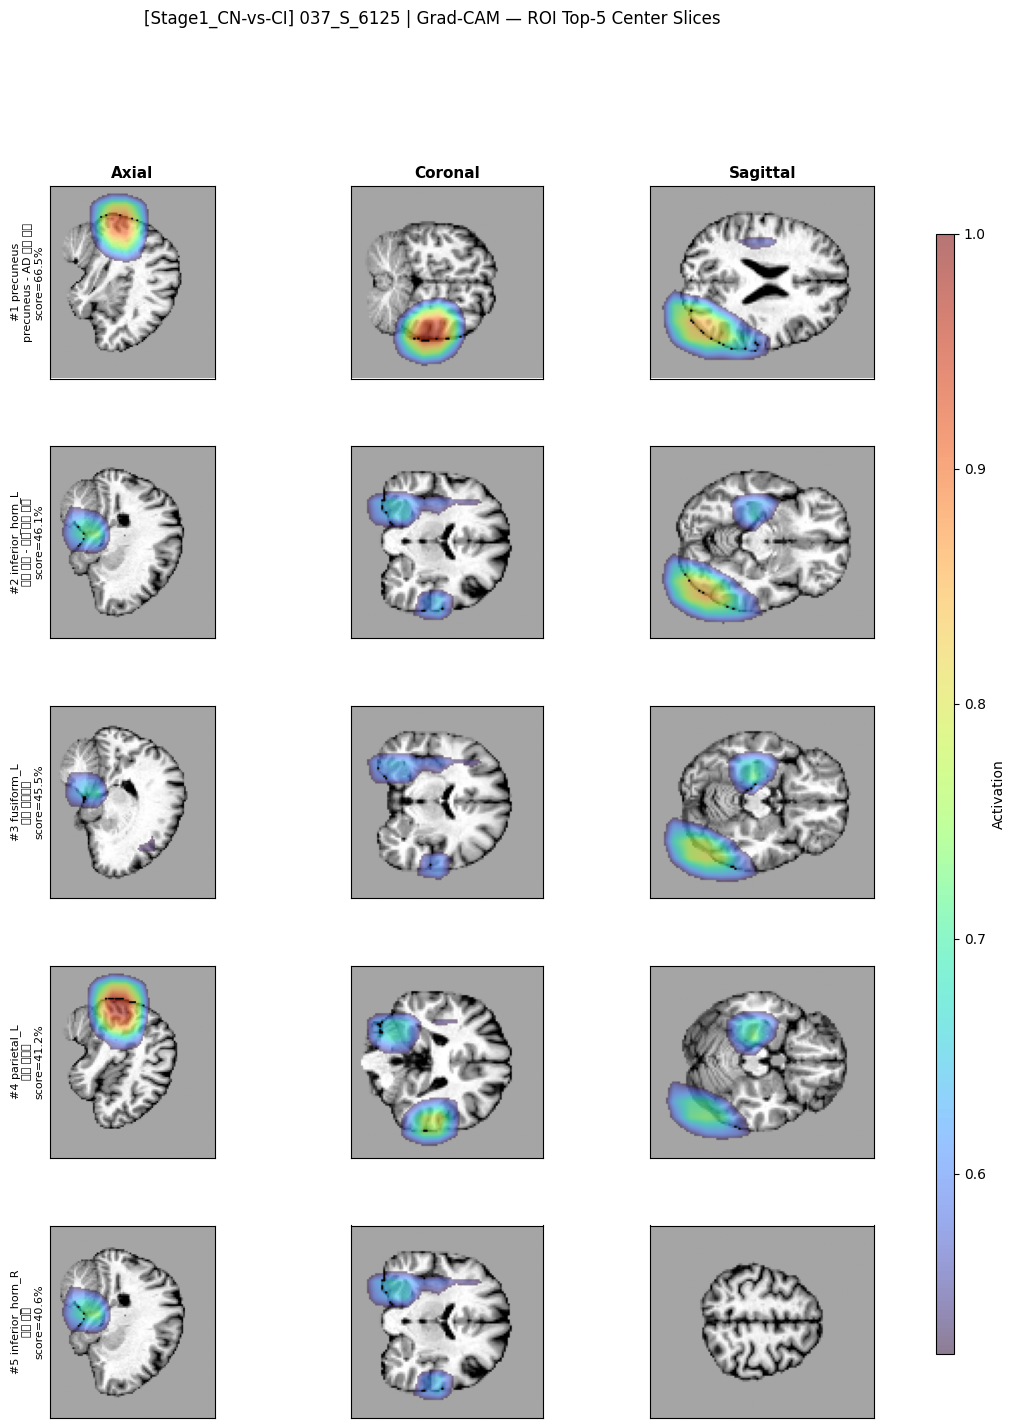


  >> [Stage2_MCI-vs-AD] ROI 이상 점수 Top-5 (brain-masked Grad-CAM):
    1. inferior_horn_L - 좌측 하각 - 해마 위축 지표: 55.45%
    2. posterior_cingulate - 후대상피질 - AD 확장 패턴: 54.78%
    3. precuneus - precuneus - AD 확장 패턴: 53.53%
    4. fusiform_L - 좌측 방추상회: 52.68%
    5. lateral_ventricle - 측뇌실 - 위축 보상 확장: 51.50%

    >> Grad-CAM — ROI Top-5 Center Slices:


/var/folders/jh/j29tjjbs3l58lhm864glxd740000gn/T/ipykernel_22080/1163351221.py:64: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  plt.savefig(output_dir / f"{safe}.png", dpi=150, bbox_inches='tight')
/var/folders/jh/j29tjjbs3l58lhm864glxd740000gn/T/ipykernel_22080/1163351221.py:64: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.savefig(output_dir / f"{safe}.png", dpi=150, bbox_inches='tight')
/var/folders/jh/j29tjjbs3l58lhm864glxd740000gn/T/ipykernel_22080/1163351221.py:64: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from font(s) DejaVu Sans.
  plt.savefig(output_dir / f"{safe}.png", dpi=150, bbox_inches='tight')
/var/folders/jh/j29tjjbs3l58lhm864glxd740000gn/T/ipykernel_22080/1163351221.py:64: UserWarning: Glyph 51656 (\N{HANGUL SYLLABLE JIL}) missing from font(s) DejaVu Sans.
  plt.savefig(output_dir / f"{safe}.png", dpi=150, bbox_inches='tight')
/var/folders/jh/j29tjjbs3l58lhm864glxd7400

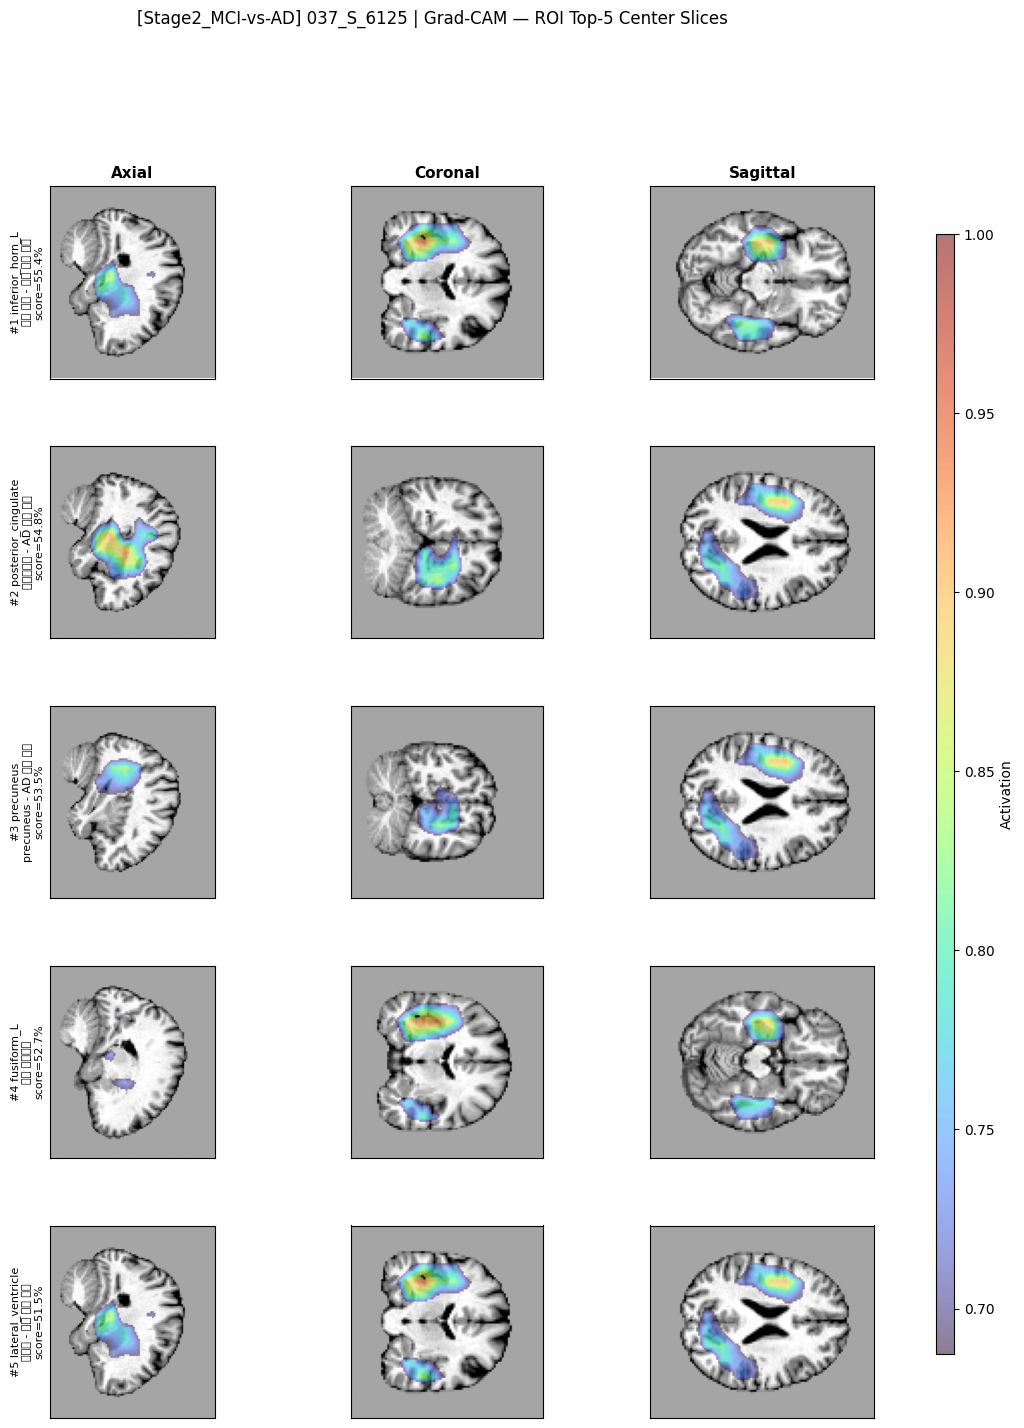


[2/5] Subject: 082_S_7117

  >> [Stage1_CN-vs-CI] ROI 이상 점수 Top-5 (brain-masked Grad-CAM):
    1. precuneus - precuneus - AD 확장 패턴: 47.88%
    2. parietal_L - 좌측 두정엽: 38.04%
    3. fusiform_L - 좌측 방추상회: 23.68%
    4. inferior_horn_L - 좌측 하각 - 해마 위축 지표: 21.29%
    5. middle_temporal_L - 좌측 중측두회: 20.66%

    >> Grad-CAM — ROI Top-5 Center Slices:


/var/folders/jh/j29tjjbs3l58lhm864glxd740000gn/T/ipykernel_22080/1163351221.py:64: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  plt.savefig(output_dir / f"{safe}.png", dpi=150, bbox_inches='tight')
/Users/machanho/Desktop/uv/ad/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


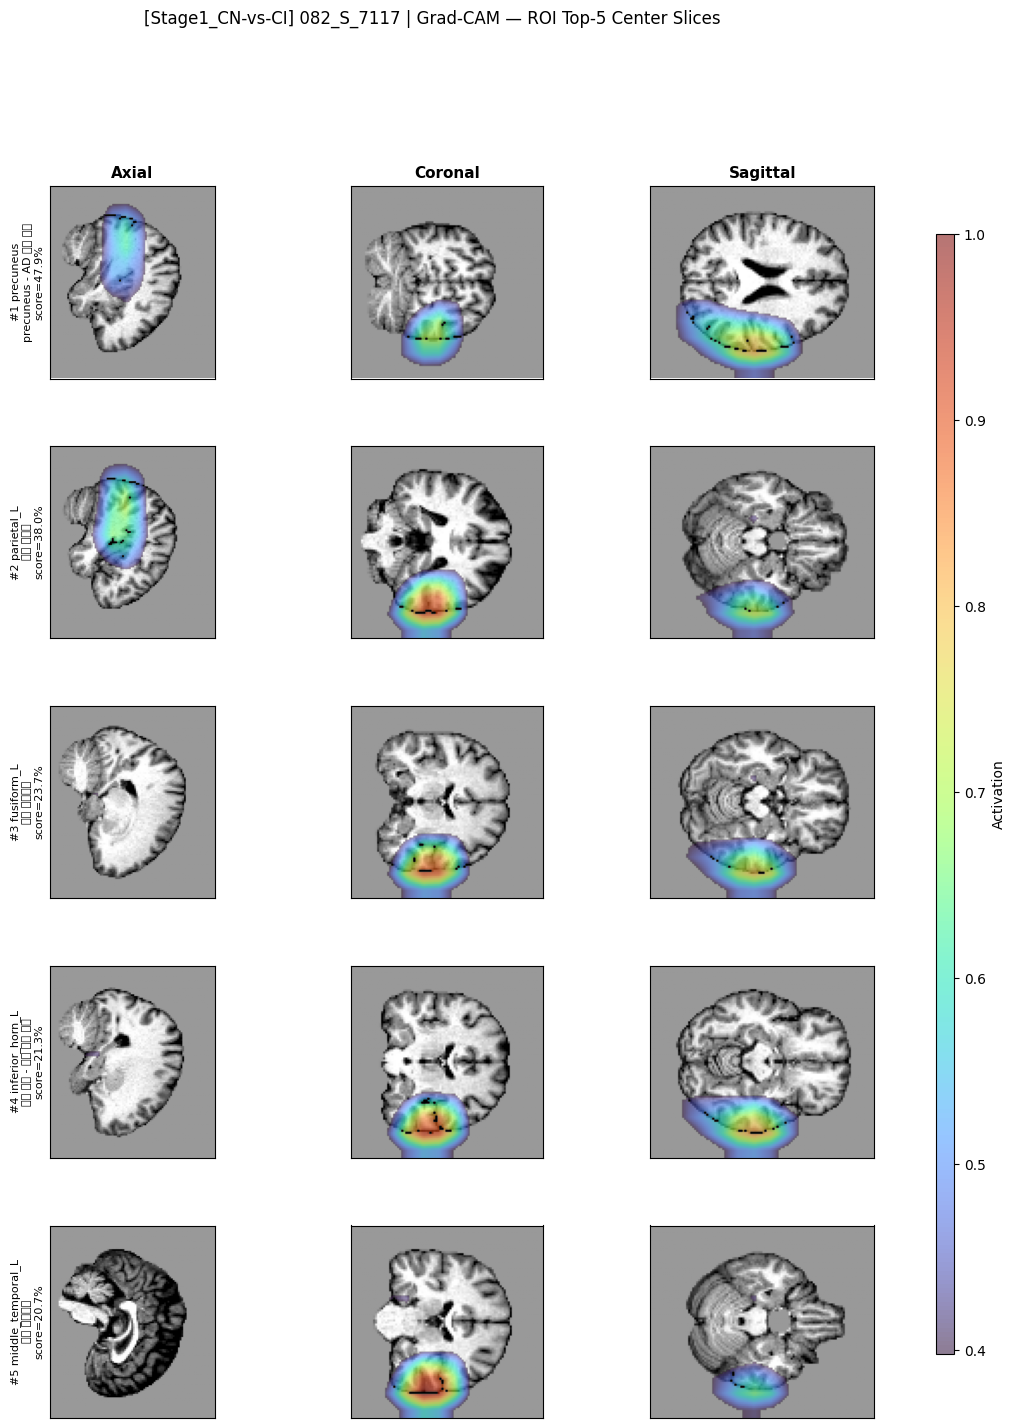


  >> [Stage2_MCI-vs-AD] ROI 이상 점수 Top-5 (brain-masked Grad-CAM):
    1. amygdala_R - 우측 편도체: 57.59%
    2. fusiform_R - 우측 방추상회: 47.66%
    3. hippocampus_R - 우측 해마: 46.10%
    4. inferior_horn_R - 우측 하각: 44.38%
    5. amygdala_L - 좌측 편도체: 39.11%

    >> Grad-CAM — ROI Top-5 Center Slices:


/var/folders/jh/j29tjjbs3l58lhm864glxd740000gn/T/ipykernel_22080/1163351221.py:64: UserWarning: Glyph 54200 (\N{HANGUL SYLLABLE PYEON}) missing from font(s) DejaVu Sans.
  plt.savefig(output_dir / f"{safe}.png", dpi=150, bbox_inches='tight')
/var/folders/jh/j29tjjbs3l58lhm864glxd740000gn/T/ipykernel_22080/1163351221.py:64: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.savefig(output_dir / f"{safe}.png", dpi=150, bbox_inches='tight')
/var/folders/jh/j29tjjbs3l58lhm864glxd740000gn/T/ipykernel_22080/1163351221.py:64: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from font(s) DejaVu Sans.
  plt.savefig(output_dir / f"{safe}.png", dpi=150, bbox_inches='tight')
/Users/machanho/Desktop/uv/ad/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54200 (\N{HANGUL SYLLABLE PYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/machanho/Desktop/uv/ad/.venv/lib/python3.10/sit

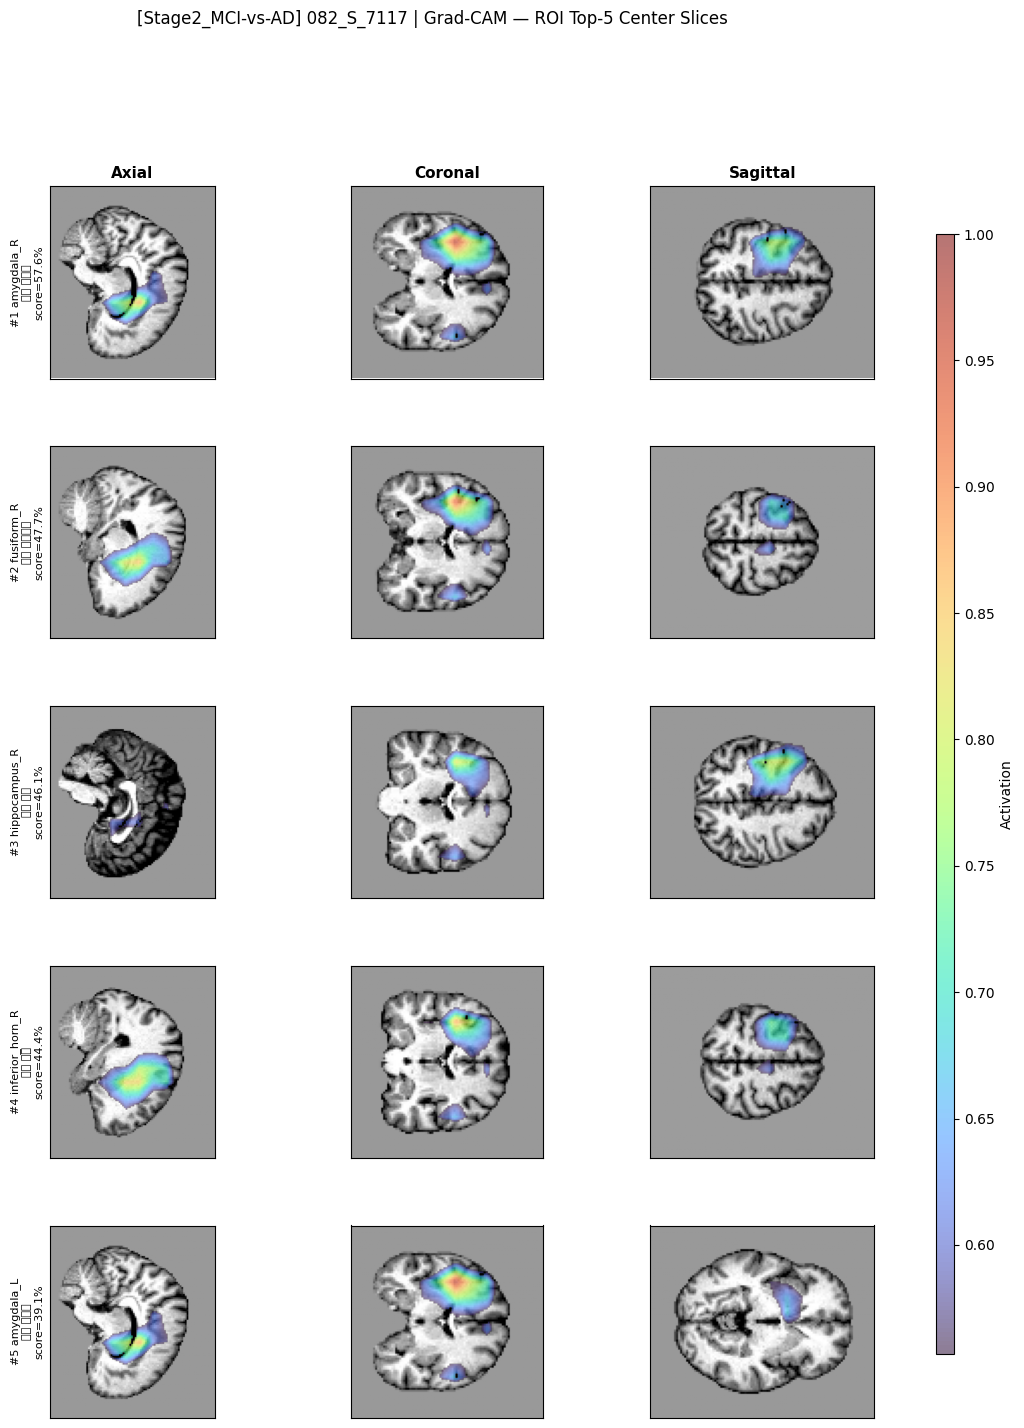


[3/5] Subject: 141_S_6041

  >> [Stage1_CN-vs-CI] ROI 이상 점수 Top-5 (brain-masked Grad-CAM):
    1. precuneus - precuneus - AD 확장 패턴: 63.65%
    2. inferior_horn_R - 우측 하각: 55.14%
    3. fusiform_R - 우측 방추상회: 55.04%
    4. inferior_temporal_R - 우측 하측두회: 43.49%
    5. parahippocampal_R - 우측 해마방회: 43.49%

    >> Grad-CAM — ROI Top-5 Center Slices:


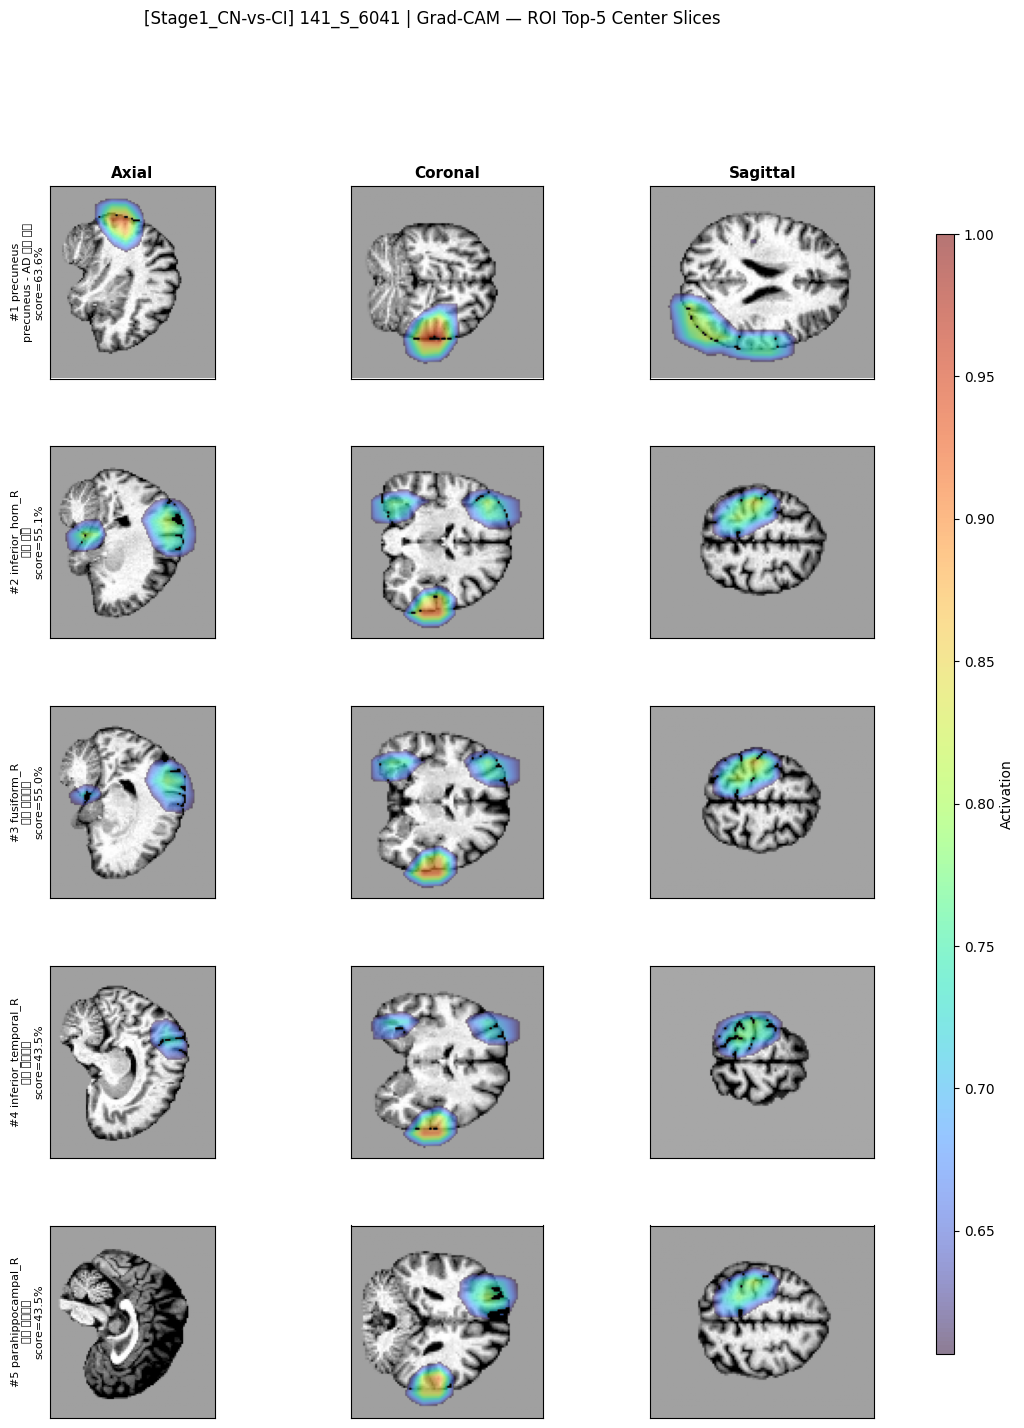


  >> [Stage2_MCI-vs-AD] ROI 이상 점수 Top-5 (brain-masked Grad-CAM):
    1. amygdala_L - 좌측 편도체: 71.12%
    2. hippocampus_L - 좌측 해마 - MCI/AD 핵심: 63.91%
    3. entorhinal_L - 좌측 엔토라이날 - MCI 초기: 52.56%
    4. parietal_L - 좌측 두정엽: 48.64%
    5. inferior_horn_L - 좌측 하각 - 해마 위축 지표: 47.20%

    >> Grad-CAM — ROI Top-5 Center Slices:


/var/folders/jh/j29tjjbs3l58lhm864glxd740000gn/T/ipykernel_22080/1163351221.py:64: UserWarning: Glyph 54645 (\N{HANGUL SYLLABLE HAEG}) missing from font(s) DejaVu Sans.
  plt.savefig(output_dir / f"{safe}.png", dpi=150, bbox_inches='tight')
/var/folders/jh/j29tjjbs3l58lhm864glxd740000gn/T/ipykernel_22080/1163351221.py:64: UserWarning: Glyph 49900 (\N{HANGUL SYLLABLE SIM}) missing from font(s) DejaVu Sans.
  plt.savefig(output_dir / f"{safe}.png", dpi=150, bbox_inches='tight')
/var/folders/jh/j29tjjbs3l58lhm864glxd740000gn/T/ipykernel_22080/1163351221.py:64: UserWarning: Glyph 50644 (\N{HANGUL SYLLABLE EN}) missing from font(s) DejaVu Sans.
  plt.savefig(output_dir / f"{safe}.png", dpi=150, bbox_inches='tight')
/var/folders/jh/j29tjjbs3l58lhm864glxd740000gn/T/ipykernel_22080/1163351221.py:64: UserWarning: Glyph 53664 (\N{HANGUL SYLLABLE TO}) missing from font(s) DejaVu Sans.
  plt.savefig(output_dir / f"{safe}.png", dpi=150, bbox_inches='tight')
/var/folders/jh/j29tjjbs3l58lhm864glxd740

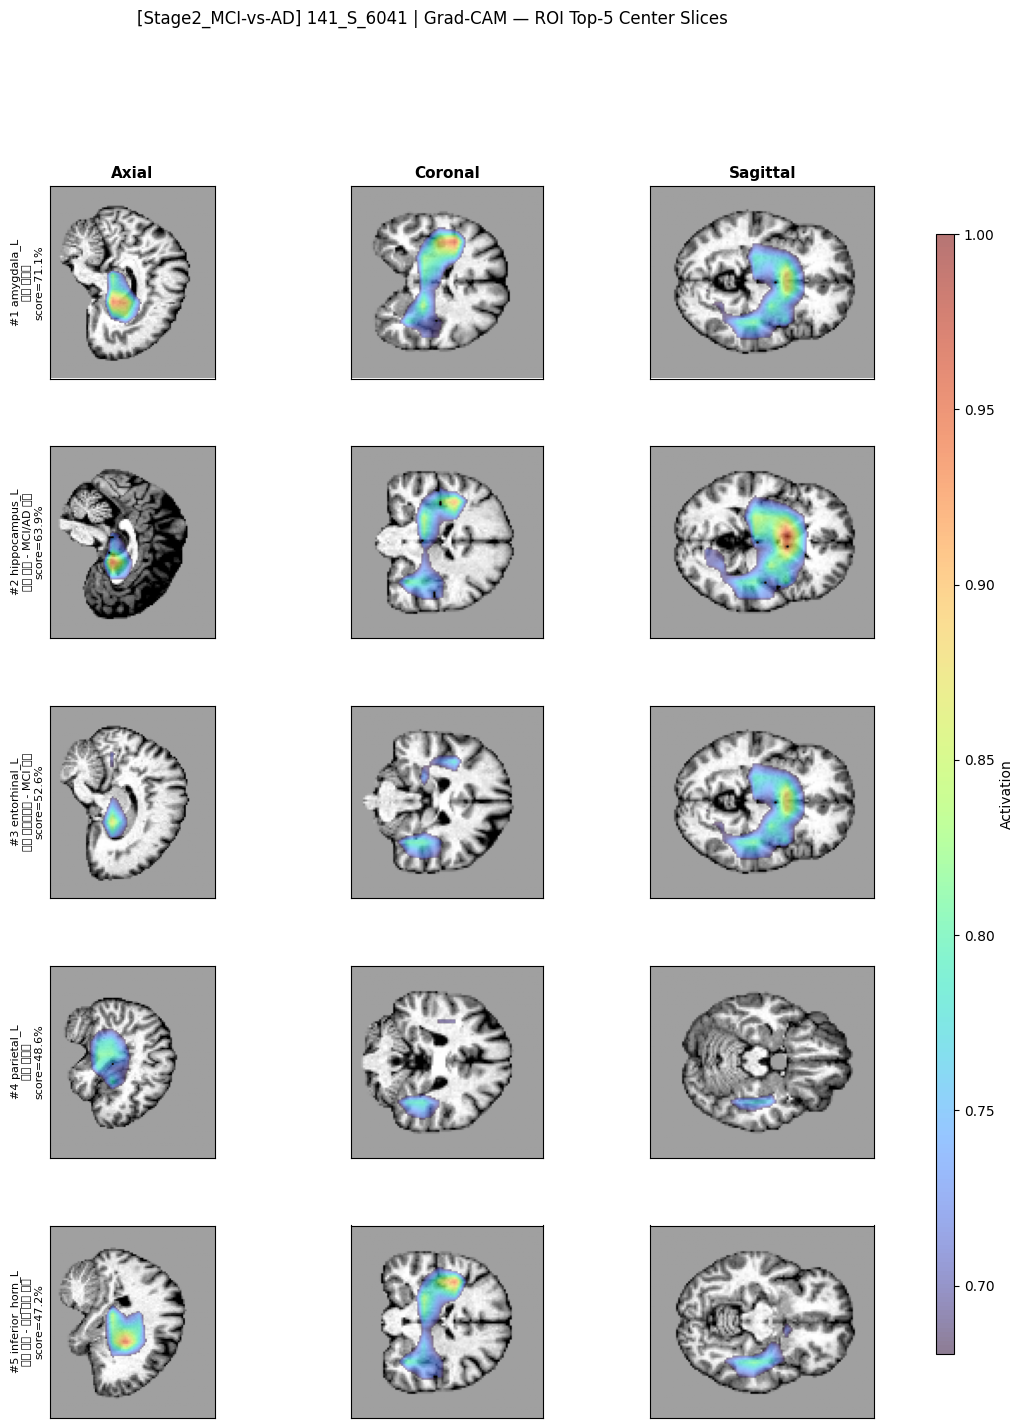


[4/5] Subject: 082_S_7117

  >> [Stage1_CN-vs-CI] ROI 이상 점수 Top-5 (brain-masked Grad-CAM):
    1. precuneus - precuneus - AD 확장 패턴: 48.73%
    2. parietal_L - 좌측 두정엽: 40.58%
    3. fusiform_L - 좌측 방추상회: 23.89%
    4. inferior_horn_L - 좌측 하각 - 해마 위축 지표: 21.67%
    5. middle_temporal_L - 좌측 중측두회: 21.03%

    >> Grad-CAM — ROI Top-5 Center Slices:


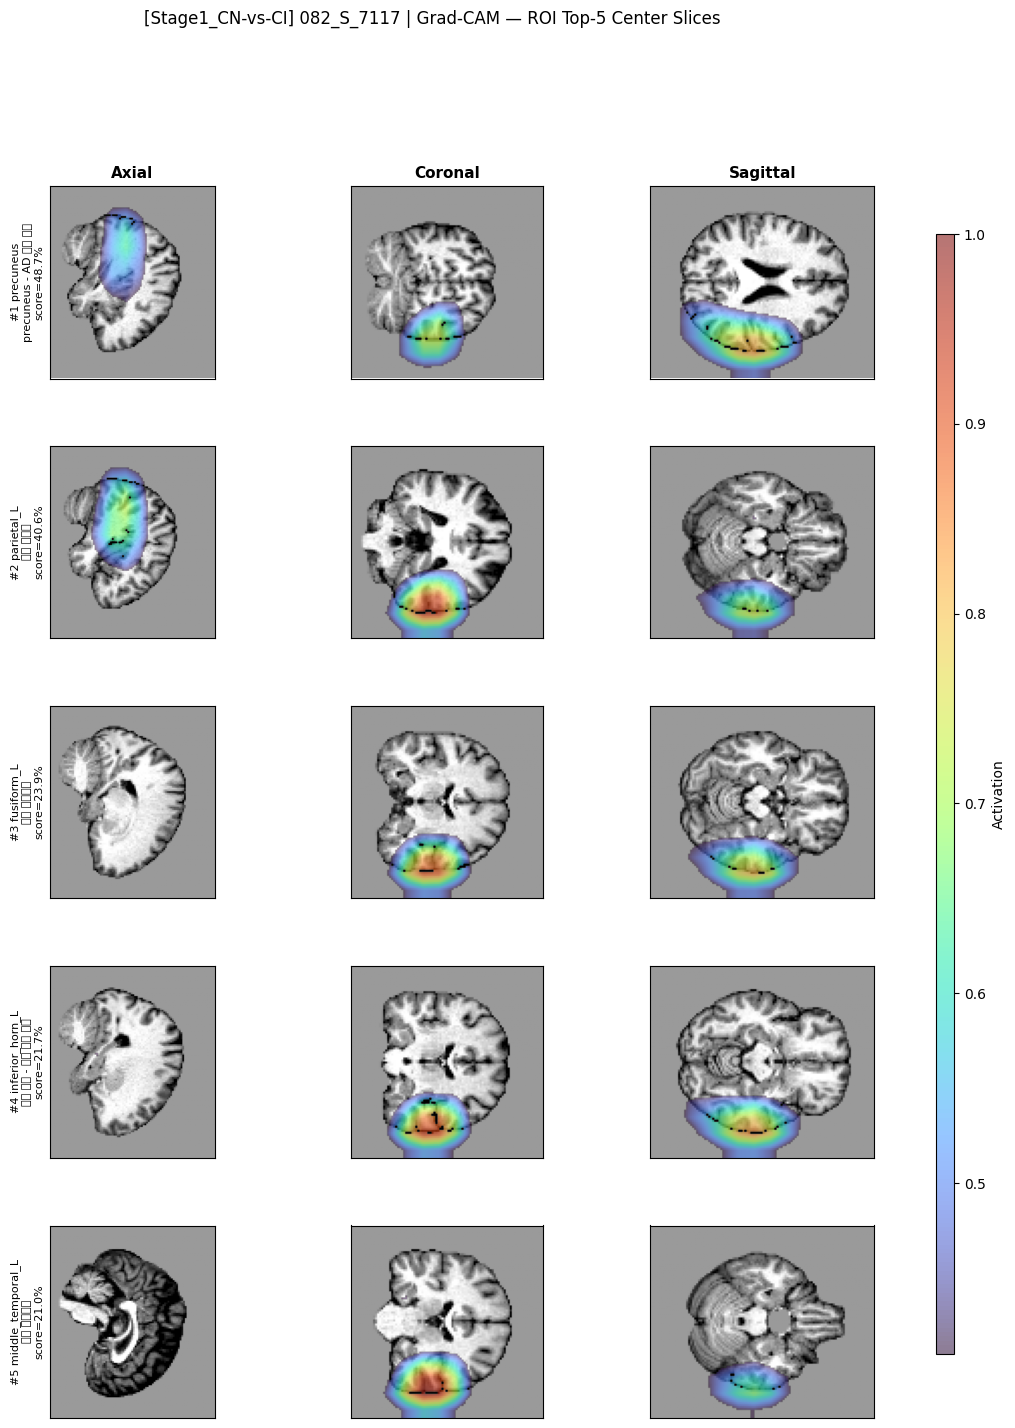


  >> [Stage2_MCI-vs-AD] ROI 이상 점수 Top-5 (brain-masked Grad-CAM):
    1. amygdala_R - 우측 편도체: 50.22%
    2. fusiform_R - 우측 방추상회: 43.13%
    3. inferior_horn_R - 우측 하각: 41.37%
    4. hippocampus_R - 우측 해마: 36.94%
    5. lateral_ventricle - 측뇌실 - 위축 보상 확장: 35.88%

    >> Grad-CAM — ROI Top-5 Center Slices:


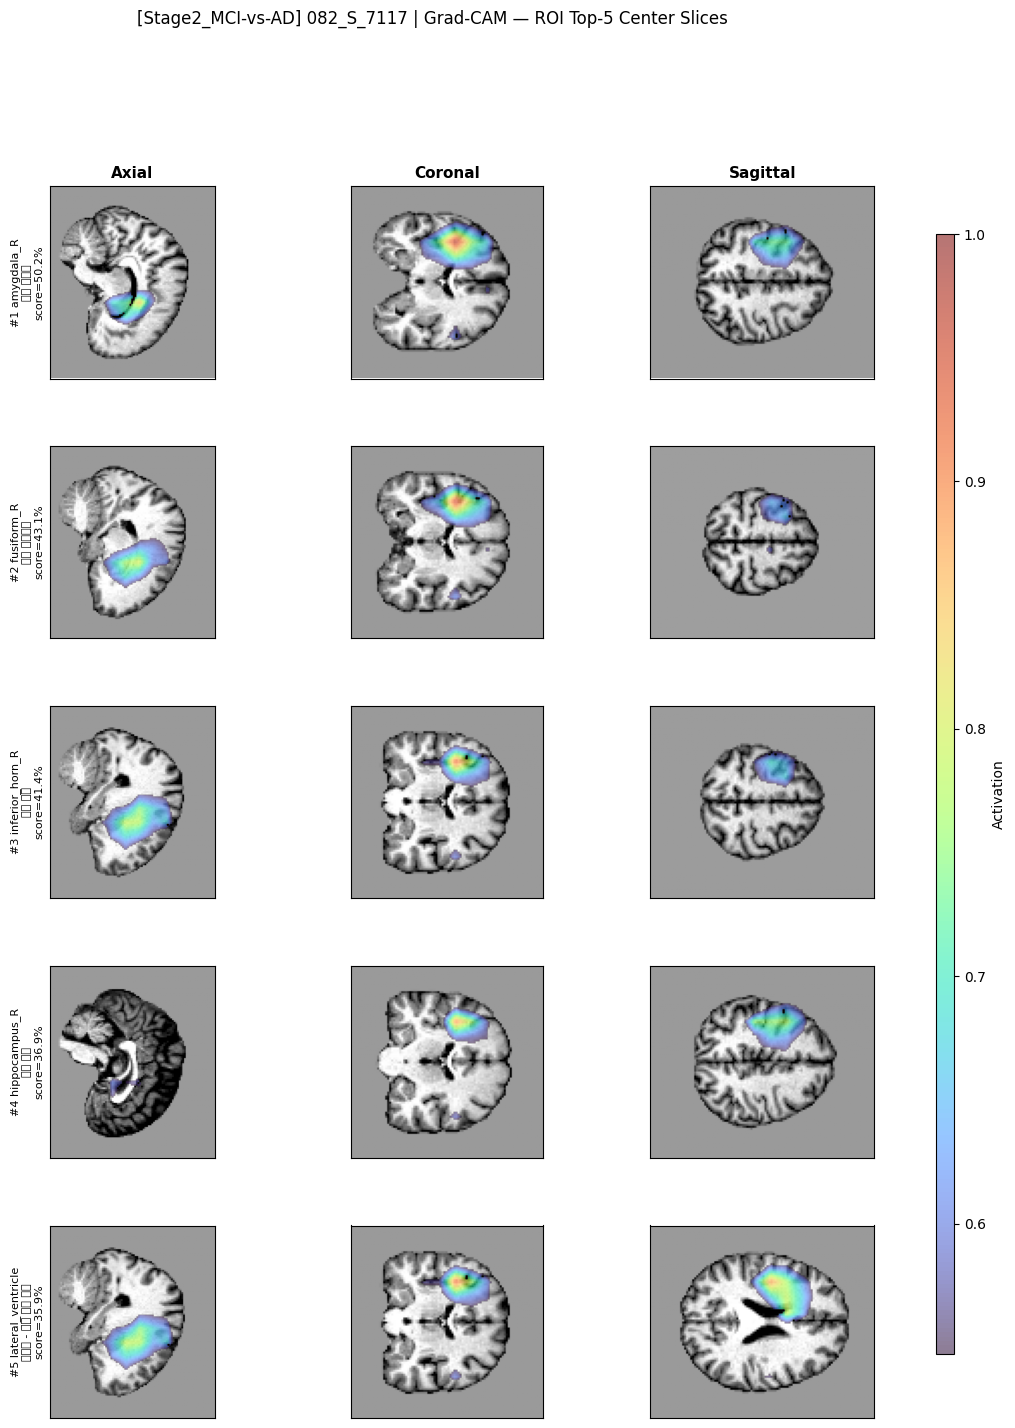


[5/5] Subject: 023_S_6702

  >> [Stage1_CN-vs-CI] ROI 이상 점수 Top-5 (brain-masked Grad-CAM):
    1. precuneus - precuneus - AD 확장 패턴: 48.24%
    2. parietal_L - 좌측 두정엽: 35.78%
    3. amygdala_R - 우측 편도체: 23.11%
    4. hippocampus_R - 우측 해마: 22.18%
    5. entorhinal_R - 우측 엔토라이날: 22.17%

    >> Grad-CAM — ROI Top-5 Center Slices:


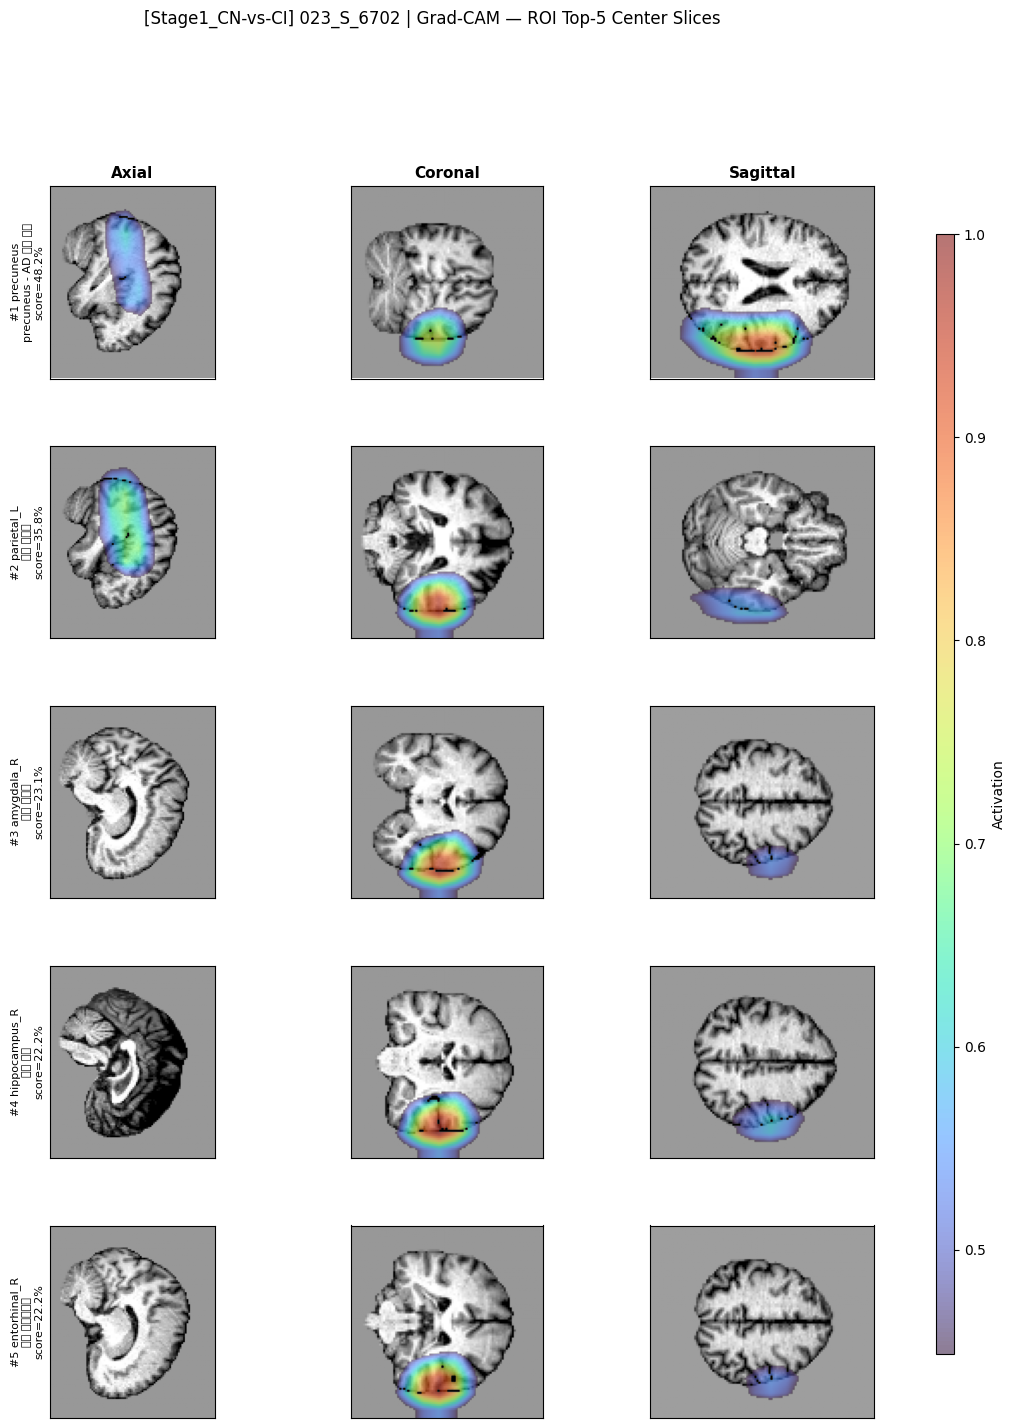


  >> [Stage2_MCI-vs-AD] ROI 이상 점수 Top-5 (brain-masked Grad-CAM):
    1. amygdala_L - 좌측 편도체: 60.22%
    2. hippocampus_L - 좌측 해마 - MCI/AD 핵심: 54.05%
    3. entorhinal_L - 좌측 엔토라이날 - MCI 초기: 43.06%
    4. fusiform_L - 좌측 방추상회: 38.60%
    5. inferior_horn_L - 좌측 하각 - 해마 위축 지표: 37.26%

    >> Grad-CAM — ROI Top-5 Center Slices:


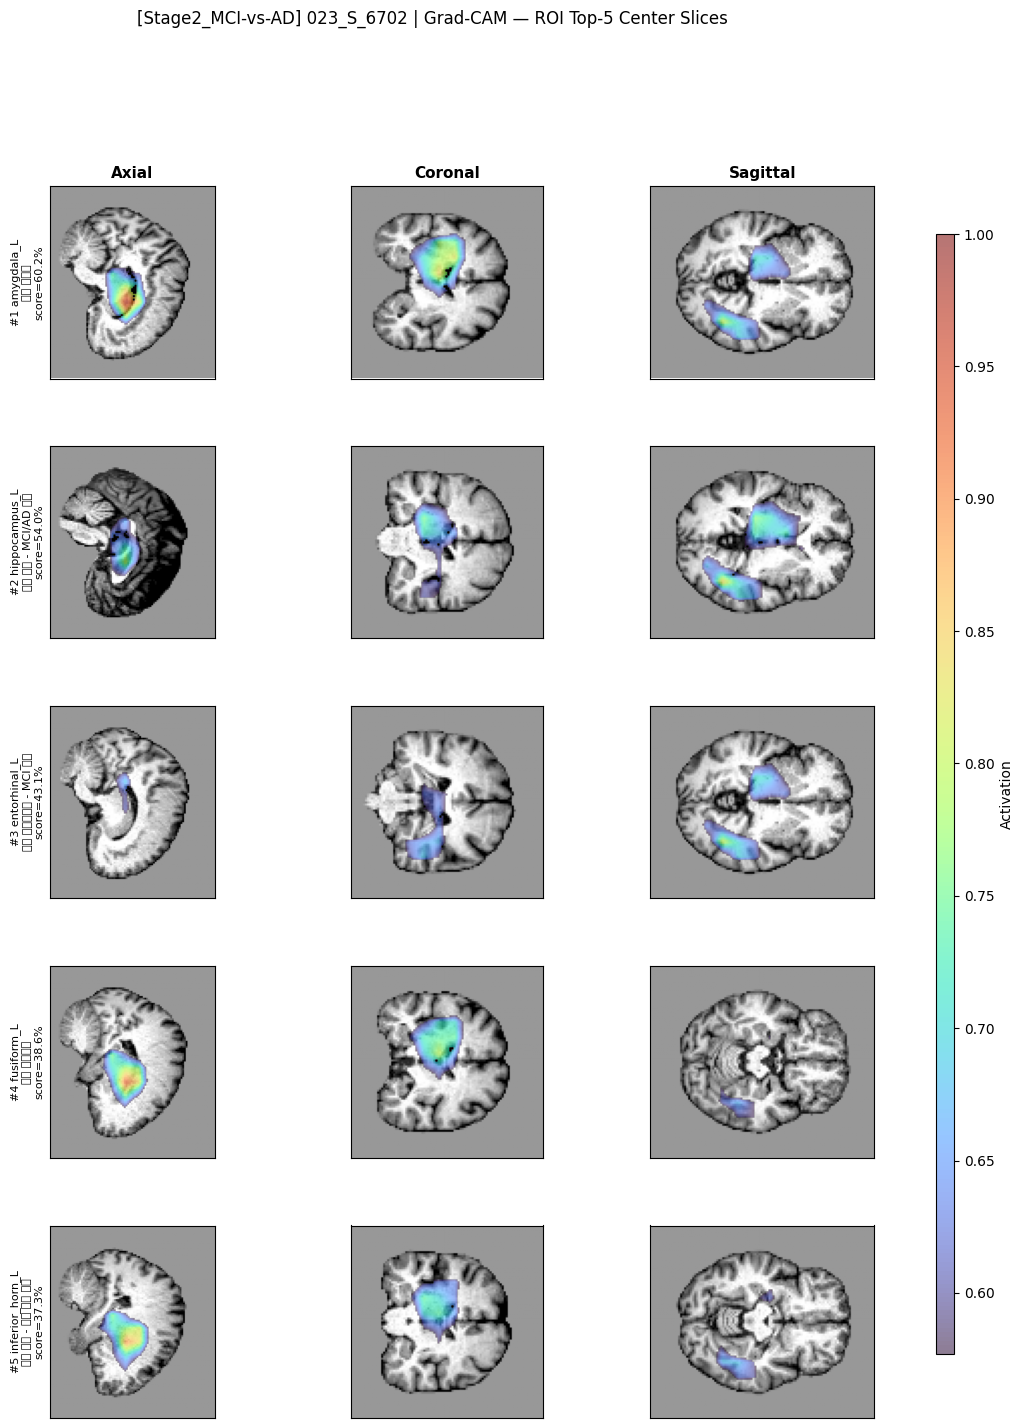


ROI 기반 CAM 시각화 완료. 결과 저장: /Users/machanho/Desktop/uv/ad/inference_output5


In [12]:
print(f"ROI 기반 CAM 시각화 시작 (MCI 정답 상위 {min(MAX_CAM_SAMPLES, len(cam_targets))}개)")
print("=" * 70)

for rank, (_, row) in enumerate(cam_targets.iterrows(), start=1):
    print(f"\n{'='*70}")
    print(f"[{rank}/{len(cam_targets)}] Subject: {row['subject_id']}")

    vol = load_nifti(row["path"])
    vol_dev = vol.to(DEVICE)
    vol_np = vol[0, 0].numpy()
    brain_mask = create_brain_mask(vol_np, threshold=0.05)

    for model, model_name, class_names, target_cls, stage_name in [
        (cn_model, "Stage1", CN_CLASS_NAMES, 1, "Stage1_CN-vs-CI"),
        (ci_model, "Stage2", CI_CLASS_NAMES, 0, "Stage2_MCI-vs-AD"),
    ]:
        with torch.enable_grad():
            target_layer = _resolve_target_layer(model)
            cam_gen = GradCAM3D(model, target_layer)
            try:
                cam_raw = cam_gen(vol_dev, class_idx=target_cls)
            finally:
                cam_gen.remove()
            cam_up = F.interpolate(cam_raw, size=TARGET_SHAPE, mode='trilinear', align_corners=False)
            gradcam_np = cam_up.detach().cpu().numpy()[0, 0]

        # 뇌 마스크 적용한 Grad-CAM으로 ROI 점수 계산
        masked_gradcam = gradcam_np * brain_mask
        roi_scores = sorted(
            compute_roi_abnormality(masked_gradcam, ROI_DEFINITIONS),
            key=lambda x: x["score"], reverse=True
        )

        print(f"\n  >> [{stage_name}] ROI 이상 점수 Top-5 (brain-masked Grad-CAM):")
        for r, item in enumerate(roi_scores[:5], start=1):
            desc = f" - {item['description']}" if item['description'] else ""
            print(f"    {r}. {item['name']}{desc}: {item['score']*100:.2f}%")

        print(f"\n    >> Grad-CAM — ROI Top-5 Center Slices:")
        visualize_roi_cam(
            vol_np, gradcam_np, "Grad-CAM", roi_scores, ROI_DEFINITIONS,
            stage_name, row["subject_id"], OUTPUT_DIR, top_k=5,
            brain_mask=brain_mask,
        )

print(f"\n{'='*70}")
print(f"ROI 기반 CAM 시각화 완료. 결과 저장: {OUTPUT_DIR}")

---
## SHAP 분석 — ROI별 기여도 막대 그래프 + SHAP CAM 오버레이

In [13]:
try:
    import shap
    HAS_SHAP = True
    print(f"SHAP 버전: {shap.__version__}")
except ImportError:
    HAS_SHAP = False
    print("SHAP 미설치. 다음 명령으로 설치 후 재실행:\n  pip install shap")


# ============================================================
# SHAP 계산
# ============================================================

def compute_shap_values(model, vol_input, background_batch, class_idx: int = 0):
    """
    shap.GradientExplainer로 복셀별 SHAP 값을 계산합니다.
    Returns: np.ndarray shape (D, H, W)
    """
    model.eval()
    explainer = shap.GradientExplainer(model, background_batch)
    shap_vals = explainer.shap_values(vol_input)

    # shap 버전별 출력 형식 처리
    if isinstance(shap_vals, list):
        # list[class] 형식: 각 원소 shape (batch, C, D, H, W)
        sv = np.array(shap_vals[class_idx])
    else:
        sv = np.array(shap_vals)
        if sv.ndim == 6:   # (batch, n_classes, C, D, H, W)
            sv = sv[:, class_idx]

    # (1, 1, D, H, W) → (D, H, W)
    while sv.ndim > 3:
        sv = sv[0]

    return sv.astype(np.float32)


def compute_roi_shap_scores(shap_np, roi_definitions):
    """
    ROI Gaussian 마스크로 SHAP 값을 가중 집계합니다.
    - raw_shap : 부호 있는 가중 평균 (예측 클래스 방향 정보)
    - score    : 절댓값 가중 평균 (중요도 순위용)
    """
    D, H, W = shap_np.shape
    dd, hh, ww = np.meshgrid(
        np.arange(D, dtype=np.float32),
        np.arange(H, dtype=np.float32),
        np.arange(W, dtype=np.float32),
        indexing='ij',
    )
    results = []
    for name, roi in roi_definitions.items():
        c = roi["center"]
        s = float(roi["sigma"])
        mask = np.exp(-((dd - c[0])**2 + (hh - c[1])**2 + (ww - c[2])**2) / (2 * s**2))
        w_sum = float(mask.sum()) + 1e-8
        raw_shap = float((shap_np * mask).sum() / w_sum)
        abs_mean = float((np.abs(shap_np) * mask).sum() / w_sum)
        results.append({
            "name":        name,
            "description": roi.get("description", ""),
            "raw_shap":    raw_shap,   # 부호 있음
            "score":       abs_mean,   # 절댓값 (정렬용)
        })
    return sorted(results, key=lambda x: x["score"], reverse=True)


# ============================================================
# ROI별 SHAP 막대 그래프
# ============================================================

def visualize_roi_shap_bar(roi_shap_scores, stage_name, subject_id, output_dir, top_k=10):
    """ROI별 SHAP 기여도 수평 막대 그래프 (부호 있는 raw_shap 사용)."""
    from matplotlib.patches import Patch

    top    = roi_shap_scores[:top_k]
    n      = len(top)
    labels = [f"{item['name']}\n({item['description']})" for item in reversed(top)]
    values = [item['raw_shap'] for item in reversed(top)]
    colors = ['#d73027' if v > 0 else '#4575b4' for v in values]

    fig, ax = plt.subplots(figsize=(10, max(4, n * 0.7)))
    bars = ax.barh(range(n), values, color=colors, alpha=0.85,
                   edgecolor='gray', linewidth=0.4)
    ax.set_yticks(range(n))
    ax.set_yticklabels(labels, fontsize=8)
    ax.set_xlabel('Weighted Mean SHAP Value (ROI Gaussian mask)', fontsize=10)
    ax.set_title(
        f"[{stage_name}] {subject_id}\nROI-level SHAP Contributions (Top-{n})",
        fontsize=12, fontweight='bold', pad=10,
    )
    ax.axvline(0, color='black', linewidth=0.8, linestyle='--')

    x_max = max(abs(v) for v in values) if values else 1.0
    for bar, val in zip(bars, values):
        x      = bar.get_width()
        offset = x_max * 0.02
        ax.text(
            x + (offset if x >= 0 else -offset),
            bar.get_y() + bar.get_height() / 2,
            f'{val:+.5f}',
            va='center', ha='left' if x >= 0 else 'right', fontsize=7,
        )

    ax.legend(
        handles=[
            Patch(facecolor='#d73027', alpha=0.85, label='양(+): 예측 클래스 방향'),
            Patch(facecolor='#4575b4', alpha=0.85, label='음(−): 반대 클래스 방향'),
        ],
        loc='lower right', fontsize=9,
    )
    plt.tight_layout()
    safe = re.sub(r"[^a-z0-9]+", "_",
                  f"{subject_id}_{stage_name}_shap_bar".lower()).strip("_")
    plt.savefig(output_dir / f"{safe}.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"    저장: {output_dir / (safe + '.png')}")


# ============================================================
# SHAP CAM 오버레이
# ============================================================

def visualize_roi_shap_cam(vol_np, shap_np, roi_shap_scores, roi_definitions,
                           stage_name, subject_id, output_dir, top_k=5,
                           brain_mask=None):
    """ROI 중심 좌표에서 |SHAP| 정규화 오버레이 시각화."""
    top_rois = roi_shap_scores[:top_k]
    n        = len(top_rois)
    if n == 0:
        return

    shap_abs  = np.abs(shap_np)
    smin, smax = shap_abs.min(), shap_abs.max()
    shap_norm  = (shap_abs - smin) / (smax - smin + 1e-8)
    thresh     = percentile_in_mask(shap_norm, brain_mask, 95, fallback=0.3)

    fig, axes = plt.subplots(n, 3, figsize=(12, 3.2 * n))
    if n == 1:
        axes = axes[np.newaxis, :]

    im = None
    for i, roi_item in enumerate(top_rois):
        roi_name = roi_item["name"]
        roi_def  = roi_definitions[roi_name]
        center   = roi_def["center"]
        desc     = roi_def.get("description", roi_name)

        view_configs = [
            ("Axial",    int(center[0]), 0),
            ("Coronal",  int(center[1]), 1),
            ("Sagittal", int(center[2]), 2),
        ]

        for j, (view_name, sl_idx, dim) in enumerate(view_configs):
            sl_idx = max(0, min(sl_idx, shap_norm.shape[dim] - 1))
            base, bm_2d = _get_slice(vol_np, brain_mask, dim, sl_idx)

            if   dim == 0: heat = shap_norm[sl_idx, :, :]
            elif dim == 1: heat = shap_norm[:, sl_idx, :]
            else:          heat = shap_norm[:, :, sl_idx]

            axes[i, j].imshow(base, cmap='gray')
            heat_masked = _mask_heat(heat, thresh, bm_2d)
            im = axes[i, j].imshow(heat_masked, cmap='hot', alpha=0.55,
                                   vmin=thresh, vmax=1)
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

            if i == 0:
                axes[i, j].set_title(view_name, fontsize=11, fontweight='bold')
            if j == 0:
                axes[i, j].set_ylabel(
                    f"#{i+1} {roi_name}\n{desc}\nSHAP={roi_item['raw_shap']:+.5f}",
                    fontsize=8,
                )

    if im is not None:
        cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
        fig.colorbar(im, cax=cbar_ax, label='|SHAP| (normalized)')

    fig.suptitle(
        f"[{stage_name}] {subject_id} | SHAP CAM — ROI Top-{n} Center Slices",
        y=0.99, fontsize=12,
    )
    plt.subplots_adjust(wspace=0.05, hspace=0.35, right=0.9)
    safe = re.sub(r"[^a-z0-9]+", "_",
                  f"{subject_id}_{stage_name}_shap_cam_roi".lower()).strip("_")
    plt.savefig(output_dir / f"{safe}.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"    저장: {output_dir / (safe + '.png')}")


print("SHAP 유틸리티 정의 완료")


SHAP 버전: 0.49.1
SHAP 유틸리티 정의 완료


In [14]:
# ============================================================
# SHAP Background 배치 준비
# ============================================================
N_BACKGROUND = 8   # MPS/CPU: 5~10 권장 (GPU: 20~50)

if HAS_SHAP:
    print(f"Background 샘플 {N_BACKGROUND}개 로드 중...")
    bg_paths = df_all.sample(min(N_BACKGROUND, len(df_all)), random_state=42)["path"].tolist()
    bg_tensors = []
    for p in bg_paths:
        try:
            bg_tensors.append(load_nifti(p).to(DEVICE))
        except Exception as e:
            print(f"  SKIP {p}: {e}")

    if not bg_tensors:
        raise RuntimeError("Background 샘플 로드 실패")

    background_batch = torch.cat(bg_tensors, dim=0)   # (N, 1, D, H, W)
    print(f"Background batch 준비 완료: {background_batch.shape}  device={background_batch.device}")
else:
    print("SHAP 미설치 — Background 배치 건너뜀")


Background 샘플 8개 로드 중...
Background batch 준비 완료: torch.Size([8, 1, 96, 112, 96])  device=mps:0


---
## ROI별 SHAP 시각화 실행

In [15]:
if not HAS_SHAP:
    print("SHAP 미설치: pip install shap")
else:
    print(f"ROI별 SHAP 시각화 시작 (MCI 정답 상위 {min(MAX_CAM_SAMPLES, len(cam_targets))}개)")
    print("=" * 70)

    for rank, (_, row) in enumerate(cam_targets.iterrows(), start=1):
        print(f"\n{'='*70}")
        print(f"[{rank}/{len(cam_targets)}] Subject: {row['subject_id']}")

        vol    = load_nifti(row["path"])
        vol_dev = vol.to(DEVICE)
        vol_np  = vol[0, 0].numpy()
        brain_mask = create_brain_mask(vol_np, threshold=0.05)

        for model, class_names, target_cls, stage_name in [
            (cn_model, CN_CLASS_NAMES, 1, "Stage1_CN-vs-CI"),
            (ci_model, CI_CLASS_NAMES, 0, "Stage2_MCI-vs-AD"),
        ]:
            print(f"\n  [{stage_name}] SHAP 계산 중 (background={N_BACKGROUND})...")
            try:
                shap_np = compute_shap_values(
                    model, vol_dev, background_batch, class_idx=target_cls
                )
            except Exception as e:
                print(f"    SHAP 계산 실패: {e}")
                continue

            roi_shap_scores = compute_roi_shap_scores(shap_np, ROI_DEFINITIONS)

            print(f"  >> [{stage_name}] ROI SHAP 기여도 Top-5:")
            for r, item in enumerate(roi_shap_scores[:5], start=1):
                desc = f" - {item['description']}" if item['description'] else ""
                print(f"    {r}. {item['name']}{desc}  SHAP={item['raw_shap']:+.5f}")

            print(f"\n    >> {stage_name} — ROI SHAP 막대 그래프:")
            visualize_roi_shap_bar(
                roi_shap_scores, stage_name, row["subject_id"], OUTPUT_DIR, top_k=10
            )

            print(f"\n    >> {stage_name} — SHAP CAM 오버레이 (ROI Top-5):")
            visualize_roi_shap_cam(
                vol_np, shap_np, roi_shap_scores, ROI_DEFINITIONS,
                stage_name, row["subject_id"], OUTPUT_DIR, top_k=5,
                brain_mask=brain_mask,
            )

    print(f"\n{'='*70}")
    print(f"ROI별 SHAP 시각화 완료. 결과 저장: {OUTPUT_DIR}")


ROI별 SHAP 시각화 시작 (MCI 정답 상위 5개)

[1/5] Subject: 037_S_6125

  [Stage1_CN-vs-CI] SHAP 계산 중 (background=8)...
    SHAP 계산 실패: MPS backend out of memory (MPS allocated: 16.38 GiB, other allocations: 3.19 MiB, max allowed: 18.13 GiB). Tried to allocate 6.15 GiB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

  [Stage2_MCI-vs-AD] SHAP 계산 중 (background=8)...
    SHAP 계산 실패: MPS backend out of memory (MPS allocated: 15.39 GiB, other allocations: 3.19 MiB, max allowed: 18.13 GiB). Tried to allocate 6.15 GiB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

[2/5] Subject: 082_S_7117

  [Stage1_CN-vs-CI] SHAP 계산 중 (background=8)...
    SHAP 계산 실패: MPS backend out of memory (MPS allocated: 15.39 GiB, other allocations: 3.19 MiB, max allowed: 18.13 GiB). Tried to allocate 6.15 GiB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATI